In [111]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2
import yfinance as yf
import sys, os
import time
import warnings
import matplotlib.lines as mlines
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from datetime import datetime, timedelta 
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from fpdf import FPDF

## Cleaning Scraped Data Functions

In [112]:
# Filter df from query
def filter_df(df, data_type, coin_name, coin_ticker):
    
    df = df.copy()
    
    df['date_scrape'] = pd.to_datetime(df['date_scrape'])
   

    if data_type == 'reddit':
        df['subreddit'] = df['subreddit'].str.lower()
        filtered_df = df[df['subreddit'] == coin_name]

    if data_type == 'twitter':
        df['user_name'] = df['user_name'].str.lower()
        filtered_df = df[df['user_name'] == coin_name]

    if data_type == 'youtube':
        df['search_word'] = df['search_word'].str.lower()
        filtered_df = df[df['search_word'] == coin_name]
        
    

    # Query price data
    coin_df = yf.download(coin_ticker, start=df['date_scrape'].min(), end=df['date_scrape'].max()).reset_index().drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
    coin_df = coin_df.rename(columns = {'Date': 'date_scrape'})

    # Merge 
    output_df = filtered_df.merge(coin_df, on='date_scrape', how = 'outer')
    output_df = output_df.ffill()
    
    #Making sure dates are in order        
    output_df = output_df.sort_values(by = ['date_scrape']).reset_index() 
    output_df = output_df.drop(['index'], axis=1)

    return output_df

#Figures out which columns are metrics
def metric_finder(df):
    metric_index = []
    
    for i in np.arange(0,len(df.columns)):
        
        if ((df.columns[i] != 'date_scrape') and (df.columns[i] != 'Close') and (df[df.columns[i]].dtype == np.number)):
            metric_index.append(i)
    
    return metric_index

## Backtesting Logic

In [113]:
#Backtest logic (updated with minmax scaling)

#x is the trigger amount, y is the window, and z is the lag
def backtesting_correlation (timeframe, data_type, df, signal, window, lag, buy_trig_shift, sell_trig_shift, fee):
    #Creating columns that show returns and percent changes for signal
    
    backtest_df = df.copy()
    
    
    if data_type == 'reddit':
        new_df = backtest_df.drop(['date_scrape', 'subreddit', 'Close'], axis=1)

    if data_type == 'twitter':
        new_df = backtest_df.drop(['date_scrape', 'user_name', 'Close'], axis=1)

    if data_type == 'youtube':
        new_df = backtest_df.drop(['date_scrape', 'search_word', 'Close'], axis=1)
        
    
    scaler = MinMaxScaler() 
    scaled_df = scaler.fit_transform(new_df)
    
    #adding functionality to determine which columns are metrics
    metric_cols = metric_finder(backtest_df)
    counter = 0
    
    
    for i in metric_cols:
        backtest_df[backtest_df.columns.values[i]] = scaled_df[:, [0+counter]]
        counter += 1
    
    
    backtest_df['returns'] = backtest_df['Close'].pct_change()
    backtest_df['sig_movement'] = backtest_df[signal].pct_change()
    #Adding column with returns affected by fees (will factor in fees later)
    backtest_df['fee_returns'] = backtest_df['returns']
    
    #Hold is a list that runs through every day and determines if we should hold, starts false bc we start not bought in
    hold = [False]
    
    
    cum_sig_mov = 1 #cumulative signal movement
    #trigger is by default average signal movement, can be shifted by certain amount of std devs
    
    sig_move_mean = backtest_df[backtest_df['sig_movement'] != np.inf]['sig_movement'][-1*timeframe:].mean()
    sig_move_std = backtest_df[backtest_df['sig_movement'] != np.inf]['sig_movement'][-1*timeframe:].std()
    
    buy_trigger = sig_move_mean + (sig_move_std * buy_trig_shift)
    sell_trigger = sig_move_mean + (sig_move_std * sell_trig_shift)
    
    print("buy: " + str(buy_trigger))
    print("sell: " + str(sell_trigger))
    
    
    for i in np.arange(1, len(df)):
        cum_sig_mov = cum_sig_mov + (cum_sig_mov * backtest_df['sig_movement'][i]) #Calculating cumulative signal movement
        
        if(i%window == 0):
            cum_sig_mov = 1 #Resetting cumulative signal movement when window expires
            
        #Entire strategy    
        if cum_sig_mov < (1 - sell_trigger): #If cumulative movement within the window decreases more than the trigger, sell
            hold.append(False)
            if(i+lag) < len(df): #Avoiding index error
                backtest_df['fee_returns'][i+lag] = backtest_df['returns'][i+lag] - (abs(backtest_df['returns'][i+lag]) * (fee))
        elif cum_sig_mov > (1 + buy_trigger): #If cumulative movement within the window increases more than the trigger, buy
            hold.append(True)
            if(i+lag) < len(df): #Avoiding index error
                backtest_df['fee_returns'][i+lag] = backtest_df['returns'][i+lag] - (abs(backtest_df['returns'][i+lag]) * (fee))
        else:    
            hold.append(hold[i-1]) #If cumulative movement within the window doesn't exceed trigger on either end, don't trade
        
    
    backtest_df['hold'] = hold #Turns holds into series
    
    #Backtests, cumulatively multiplies returns where hold is true, shifts returns by lag specified
    backtest_df['strategy_perf'] = (backtest_df['fee_returns'].shift(-1 + (lag * -1)) * backtest_df['hold'] + 1).cumprod()
    backtest_df['holding_perf'] = (backtest_df['returns'].shift(-1) + 1).cumprod()  # benchmark returns
    backtest_df.to_csv(str(signal) + 'dataframe.csv')
    
    return backtest_df

In [114]:
#Plots returns against holding the coin
def backtest_plotter(backtest_df, signal, backtest_lag): #Remember to add momentum back in
    
    #pd.set_option("display.max_rows", None, "display.max_columns", None)
    pd.set_option("max_rows", 10)
    pd.set_option("max_columns", 10)
    
    buys = []
    sells = []
    
    
    for i in np.arange(1,len(backtest_df['hold'])):
        if((backtest_df['hold'][i] == True) and (backtest_df['hold'][i-1] == False)):
            buys.append(i-1)
        if((backtest_df['hold'][i] == False) and (backtest_df['hold'][i-1] == True)):  
            sells.append(i-1)

   
    fig = plt.figure(figsize=(20,8))
    plt.style.use("fivethirtyeight")
    #plt.title("{} Backtest".format(signal))
    plt.ylabel("Multiple of Returns")
    plt.xticks(fontsize=15)
    #plt.xticks(np.arange(0, len(df['date_scrape']), 5))
    plt.plot(backtest_df['date_scrape'] + (timedelta(days=backtest_lag)), backtest_df['strategy_perf'], label="strategy", color = '#30a2da')
    #plt.plot(momentum_df['date_scrape'], momentum_df['total']+1, label="momentum", color = '#6d904f')
    plt.plot(backtest_df['date_scrape'], backtest_df['holding_perf'], label="holding", color = '#fc4f30')
    
    for i in buys:
        plt.plot(backtest_df['date_scrape'][i] + (timedelta(days=backtest_lag)), backtest_df['strategy_perf'][i], color = '#5c5c5c', marker='^', markerfacecolor='#5c5c5c', markeredgecolor='#d3d3d3', markeredgewidth= 1,  markersize=12)
    for i in sells:
        plt.plot(backtest_df['date_scrape'][i] + (timedelta(days=backtest_lag)), backtest_df['strategy_perf'][i], color = '#5c5c5c', marker='s', markerfacecolor='#5c5c5c', markeredgecolor='#d3d3d3', markeredgewidth= 1,  markersize=12)
        
    buy_marker = mlines.Line2D([], [], color = '#30a2da', marker='^', markeredgewidth=0, markerfacecolor='#5c5c5c', markersize=12, label='Buys')
    sell_marker = mlines.Line2D([], [], color = '#30a2da', marker='s', markeredgewidth=0, markerfacecolor='#5c5c5c', markersize=12, label='Sells')
    
    main_legend = plt.legend(loc = 1)
    ax = plt.gca().add_artist(main_legend)
    
    plt.legend(handles=[buy_marker, sell_marker], loc = 2)
    
    return fig

In [115]:
def daily_signal(dataframe, data_type, metric, coin, ticker):
    
    if(backtest_df['hold'].iloc[-2] == True):
        if(backtest_df['hold'].iloc[-1] == True):
            return "Keep Position"
        else:
            return "Sell"
    
    if(backtest_df['hold'].iloc[-2] == False):
        if(backtest_df['hold'].iloc[-1] == False):
            return "Keep Position"
        else:
            return "Buy"

## Pulling Data

In [116]:
# Initiate Datagrip (PostgreSQL) connection
PASSWORD = "***"
conn = psycopg2.connect(PASSWORD)
conn.autocommit = True
cur = conn.cursor()

In [117]:
sql_twitter_query = """
    SELECT date_scrape, user_name, AVG(retweet_count) AS retweet_count, AVG(favorite_count) AS favorite_count, AVG(account_followers) AS account_followers
    FROM twitter_df
    GROUP BY user_name, date_scrape
    ORDER BY date_scrape
"""

twitter_df = pd.read_sql_query(sql_twitter_query, conn)
twitter_df['user_name'].unique()

array(['LTCFoundation', 'Tether_to', 'Algorand', 'Polkadot', 'Ripple',
       'Cardano', 'dogecoin', 'Bitcoin', 'ethereum', 'cosmos',
       'StellarOrg', 'monero', 'tezos', 'block_one_', 'chainlink',
       'MakerDAO', 'Filecoin', 'Tronfoundation', 'oceanprotocol',
       'AaveAave', 'AxieInfinity', 'FantomFDN', 'numerai', 'brave',
       'avalancheavax', 'cryptocom', 'solana', '0xPolygon', 'binance',
       'terra_money', 'decentraland', 'helium', 'Uniswap'], dtype=object)

array(['LTCFoundation', 'Tether_to', 'Algorand', 'Polkadot', 'Ripple',
       'Cardano', 'dogecoin', 'Bitcoin', 'ethereum', 'cosmos',
       'StellarOrg', 'monero', 'tezos', 'block_one_', 'chainlink',
       'MakerDAO', 'Filecoin', 'Tronfoundation', 'oceanprotocol',
       'AaveAave', 'AxieInfinity', 'FantomFDN', 'numerai', 'brave',
       'avalancheavax', 'cryptocom', 'solana', '0xPolygon', 'binance',
       'terra_money', 'decentraland', 'helium', 'Uniswap'], dtype=object)

array(['LTCFoundation', 'Tether_to', 'Algorand', 'Polkadot', 'Ripple',
       'Cardano', 'dogecoin', 'Bitcoin', 'ethereum', 'cosmos',
       'StellarOrg', 'monero', 'tezos', 'block_one_', 'chainlink',
       'MakerDAO', 'Filecoin', 'Tronfoundation', 'oceanprotocol',
       'AaveAave', 'AxieInfinity', 'FantomFDN', 'numerai', 'brave',
       'avalancheavax', 'cryptocom', 'solana', '0xPolygon', 'binance',
       'terra_money', 'decentraland', 'helium', 'Uniswap'], dtype=object)

In [118]:
sql_reddit_query = """
    SELECT date_scrape, subreddit, AVG(subreddit_subs) AS subreddit_subs, AVG(num_comms) AS num_comms, AVG(score) AS score
    FROM reddit_df
    GROUP BY subreddit, date_scrape
    ORDER BY date_scrape
    """

reddit_df = pd.read_sql_query(sql_reddit_query, conn)
reddit_df['subreddit'].unique()

array(['algorand', 'Bitcoin', 'cardano', 'cosmosnetwork', 'dogecoin',
       'dot', 'ethereum', 'litecoin', 'Ripple', 'Stellar', 'Chainlink',
       'eos', 'filecoin', 'MakerDAO', 'Monero', 'tezos', 'Tronix',
       '0xPolygon', 'Aave_Official', 'Avax', 'AxieInfinity', 'binance',
       'brave_browser', 'cro', 'decentraland', 'FantomFoundation',
       'HeliumNetwork', 'numerai', 'oceanprotocol', 'solana', 'terraluna',
       'UniSwap'], dtype=object)

array(['algorand', 'Bitcoin', 'cardano', 'cosmosnetwork', 'dogecoin',
       'dot', 'ethereum', 'litecoin', 'Ripple', 'Stellar', 'Chainlink',
       'eos', 'filecoin', 'MakerDAO', 'Monero', 'tezos', 'Tronix',
       '0xPolygon', 'Aave_Official', 'Avax', 'AxieInfinity', 'binance',
       'brave_browser', 'cro', 'decentraland', 'FantomFoundation',
       'HeliumNetwork', 'numerai', 'oceanprotocol', 'solana', 'terraluna',
       'UniSwap'], dtype=object)

array(['algorand', 'Bitcoin', 'cardano', 'cosmosnetwork', 'dogecoin',
       'dot', 'ethereum', 'litecoin', 'Ripple', 'Stellar', 'Chainlink',
       'eos', 'filecoin', 'MakerDAO', 'Monero', 'tezos', 'Tronix',
       '0xPolygon', 'Aave_Official', 'Avax', 'AxieInfinity', 'binance',
       'brave_browser', 'cro', 'decentraland', 'FantomFoundation',
       'HeliumNetwork', 'numerai', 'oceanprotocol', 'solana', 'terraluna',
       'UniSwap'], dtype=object)

In [119]:
coin = 'cardano'
ticker = 'ADA-USD'

#twitter signals and hitrates
retweets_action = []
retweets_hitrate = []
favorites_action = []
favorites_hitrate = []
followers_action = []
followers_hitrate = []

#reddit signals and hitrates
num_comms_action = []
num_comms_hitrate = []
score_action = []
score_hitrate = []
subs_action = []
subs_hitrate = []

In [120]:
cardano_reddit_df = filter_df(reddit_df, 'reddit', coin, ticker) #dataframe that goes into everything
cardano_reddit_df['subreddit_subs'] = cardano_reddit_df['subreddit_subs'].diff() #adjusting subreddit_subs so it's more useful

cardano_twitter_df = filter_df(twitter_df, 'twitter', coin, ticker) #dataframe that goes into everything
cardano_twitter_df['account_followers'] = cardano_twitter_df['account_followers'].diff() #adjusting subreddit_subs so it's more useful

cardano_df = pd.merge(cardano_reddit_df, cardano_twitter_df)

def corr_tracker(df, timespan):
    df = df.drop(['Close'], axis = 1)[(-1*timespan):]
    display(df.corr()) 

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed




## Twitter

In [121]:
#Cardano Twitter Retweets
#Last tuned 1/9/2022

#This is where you specify details of the report (what API, how many lag days, moving average)
dataframe = twitter_df
data_type = 'twitter'
signal = 'retweet_count'
moving_avg = 0 #Smooths signal, takes average across specified window 
backtest_lag = 1 #Calculates predictive power into the future by lagging prices by x amount of days


#backtest variables
window = 3 #Length of days in which if signal goes up/down it would qualify as a buy/sell trigger
timeframe = 60 #How many days of past data to use to set as benchmark signal movement
buy_shift = 0.5 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift = 0.5
fee = 0.01
risk_free_rate = 0.0119

In [122]:
#Here we run the entire backtest with the above params
#We print out the returns, when tuning try to maximize this value
df = filter_df(dataframe, data_type, coin, ticker) #dataframe that goes into everything
metric_cols = metric_finder(df) #defines which columns are metrics
warnings.filterwarnings("ignore")
backtest_df = backtesting_correlation(timeframe, data_type, df, signal, window, backtest_lag, buy_shift, sell_shift, fee)
display(backtest_df)
print(backtest_df['strategy_perf'].iloc[(-1*backtest_lag) - 2])

[*********************100%***********************]  1 of 1 completed
buy: 0.09696439249090738
sell: 0.09696439249090738

buy: 0.09696439249090738
sell: 0.09696439249090738

buy: 0.09696439249090738
sell: 0.09696439249090738


date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866           0.000000   
1    2021-03-08   cardano       0.121970        0.138130           0.002000   
2    2021-03-09   cardano       0.137298        0.144704           0.004193   
3    2021-03-10   cardano       0.117404        0.155403           0.006076   
4    2021-03-11   cardano       0.129797        0.155762           0.008643   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.994340   
321  2022-01-22   cardano       0.551718        0.555283           0.995700   
322  2022-01-23   cardano       0.532558        0.531001           0.996978   
323  2022-01-24   cardano       0.270845        0.274063           0.998423   
324  2022-01-25   cardano       0.274921        0.269386           1.000000   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...     -0.592148    -0.013512  False       1.000000      1.054523  
2    ...      0.125668     0.068277  False       1.000000      1.001444  
3    ...     -0.144893    -0.050838  False       1.000000      0.992432  
4    ...      0.105556    -0.008998   True       1.061135      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.052208    -0.107167   True       1.901971      0.941192  
321  ...      0.007444    -0.050316   True       1.807458      0.990298  
322  ...     -0.034727     0.052174   True       1.807458      0.941088  
323  ...     -0.491427    -0.049692  False            NaN      0.941088  
324  ...      0.015051     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866           0.000000   
1    2021-03-08   cardano       0.121970        0.138130           0.002000   
2    2021-03-09   cardano       0.137298        0.144704           0.004193   
3    2021-03-10   cardano       0.117404        0.155403           0.006076   
4    2021-03-11   cardano       0.129797        0.155762           0.008643   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.994340   
321  2022-01-22   cardano       0.551718        0.555283           0.995700   
322  2022-01-23   cardano       0.532558        0.531001           0.996978   
323  2022-01-24   cardano       0.270845        0.274063           0.998423   
324  2022-01-25   cardano       0.274921        0.269386           1.000000   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...     -0.592148    -0.013512  False       1.000000      1.054523  
2    ...      0.125668     0.068277  False       1.000000      1.001444  
3    ...     -0.144893    -0.050838  False       1.000000      0.992432  
4    ...      0.105556    -0.008998   True       1.061135      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.052208    -0.107167   True       1.901971      0.941192  
321  ...      0.007444    -0.050316   True       1.807458      0.990298  
322  ...     -0.034727     0.052174   True       1.807458      0.941088  
323  ...     -0.491427    -0.049692  False            NaN      0.941088  
324  ...      0.015051     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866           0.000000   
1    2021-03-08   cardano       0.121970        0.138130           0.002000   
2    2021-03-09   cardano       0.137298        0.144704           0.004193   
3    2021-03-10   cardano       0.117404        0.155403           0.006076   
4    2021-03-11   cardano       0.129797        0.155762           0.008643   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.994340   
321  2022-01-22   cardano       0.551718        0.555283           0.995700   
322  2022-01-23   cardano       0.532558        0.531001           0.996978   
323  2022-01-24   cardano       0.270845        0.274063           0.998423   
324  2022-01-25   cardano       0.274921        0.269386           1.000000   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...     -0.592148    -0.013512  False       1.000000      1.054523  
2    ...      0.125668     0.068277  False       1.000000      1.001444  
3    ...     -0.144893    -0.050838  False       1.000000      0.992432  
4    ...      0.105556    -0.008998   True       1.061135      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.052208    -0.107167   True       1.901971      0.941192  
321  ...      0.007444    -0.050316   True       1.807458      0.990298  
322  ...     -0.034727     0.052174   True       1.807458      0.941088  
323  ...     -0.491427    -0.049692  False            NaN      0.941088  
324  ...      0.015051     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

1.8074581244855912
1.8074581244855912
1.8074581244855912


In [123]:
#Calculating hit rate for tuning, try to maximize
num_trues = sum((df['Close'].diff(periods = backtest_lag) > 0) == (df[signal].diff(periods = backtest_lag) > 0))
        
hit_rate = (num_trues / len(df)) 
retweets_hitrate.append(hit_rate)
print(hit_rate)

0.52
0.52
0.52


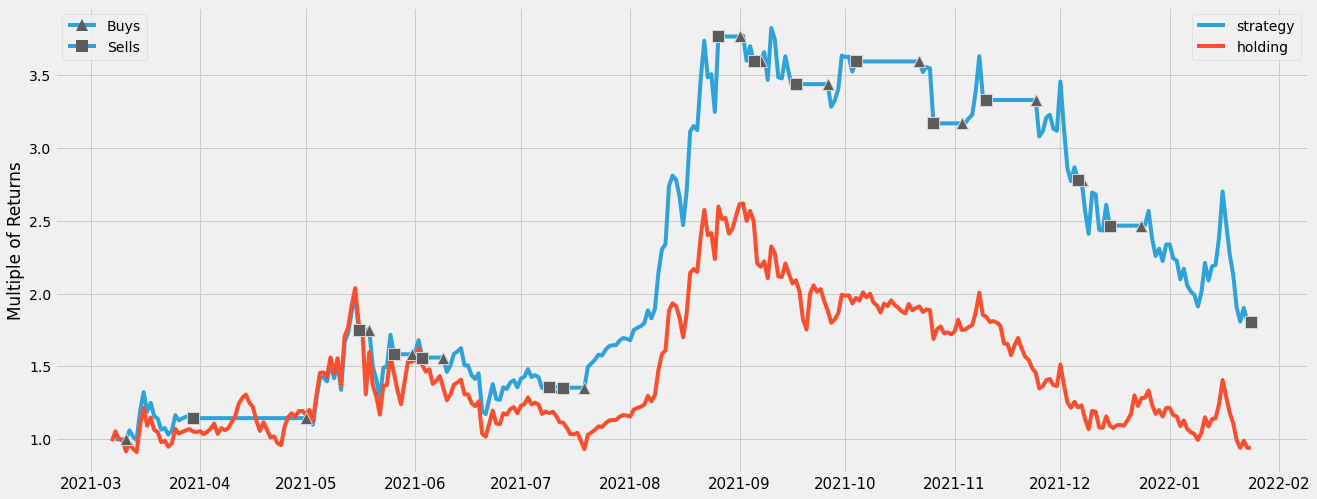

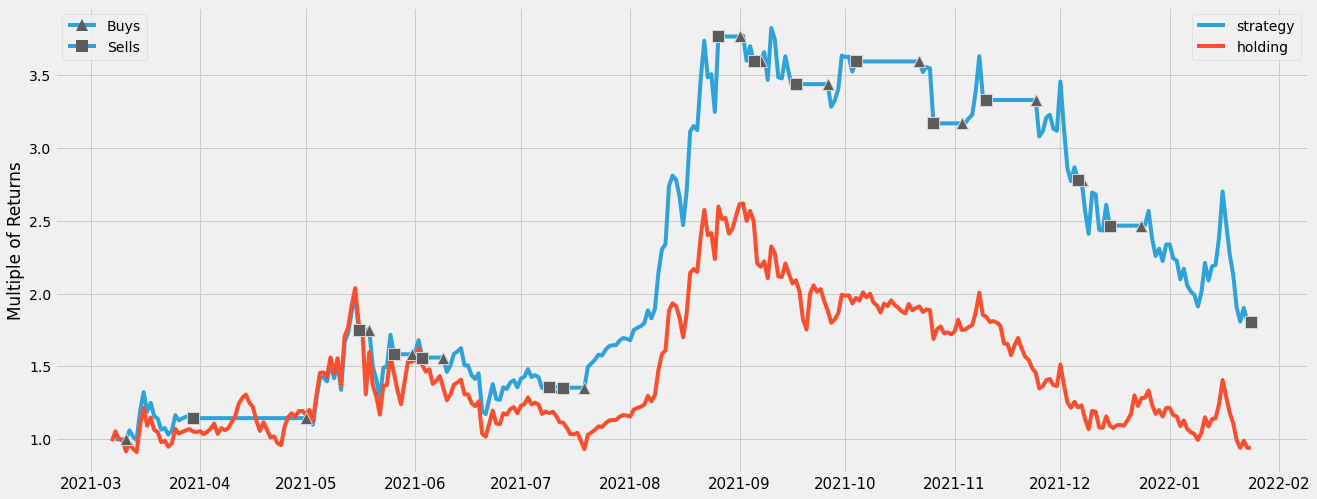

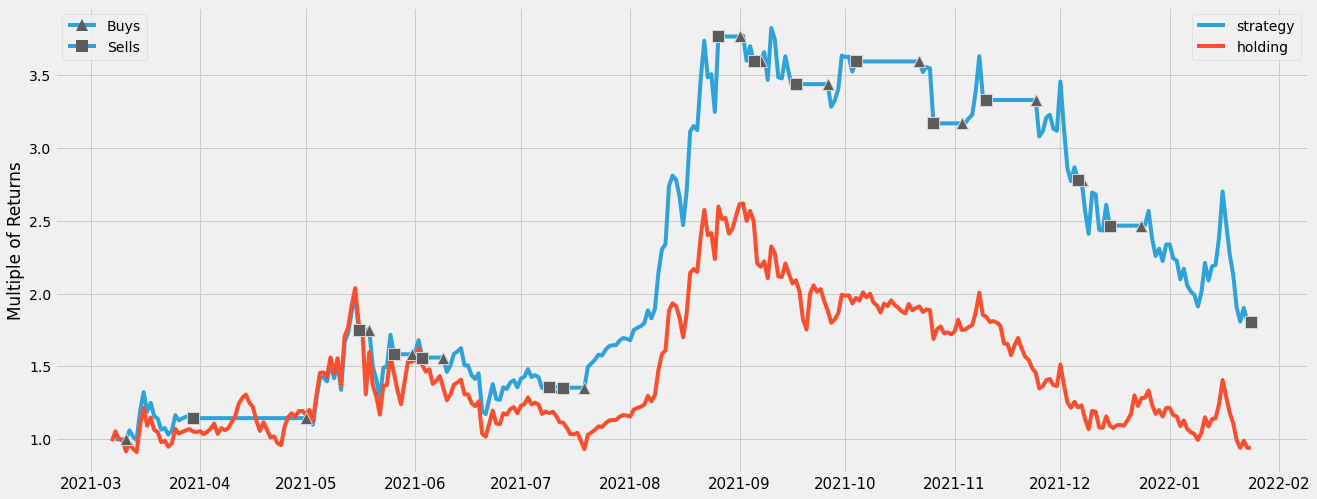

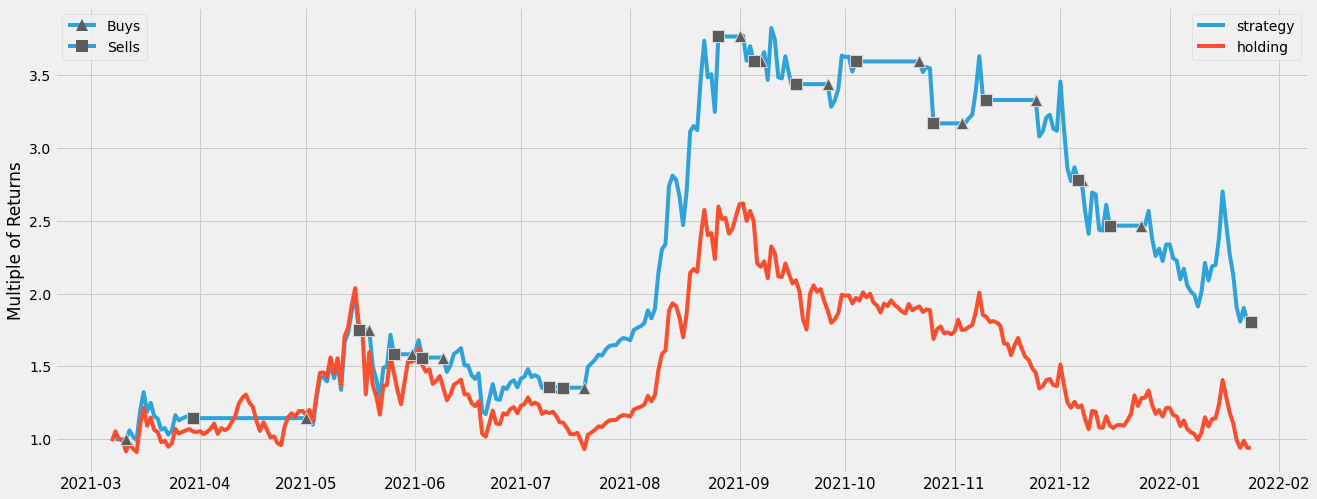

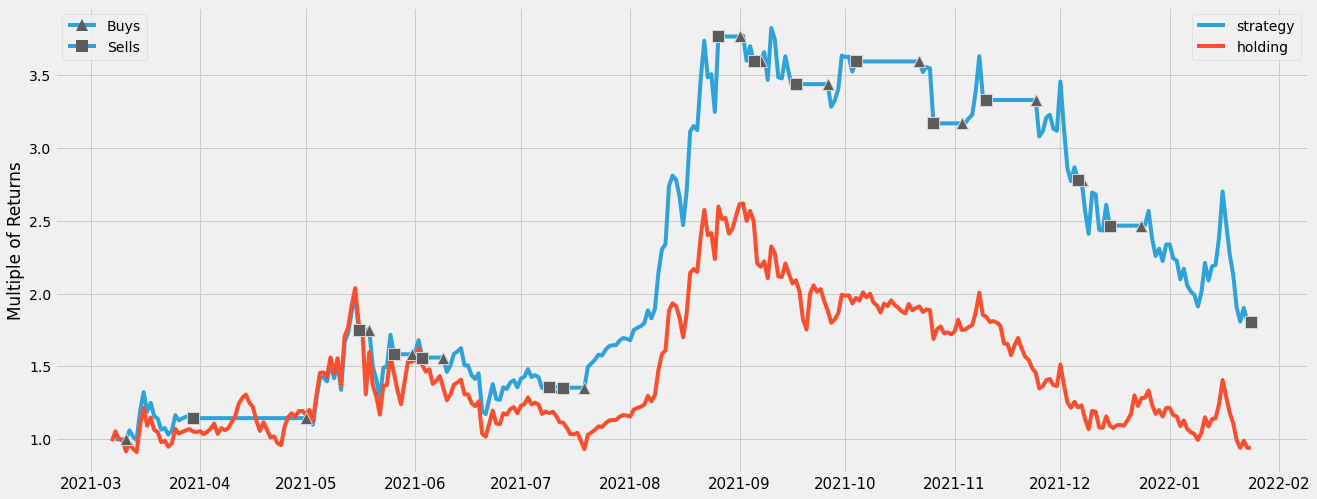

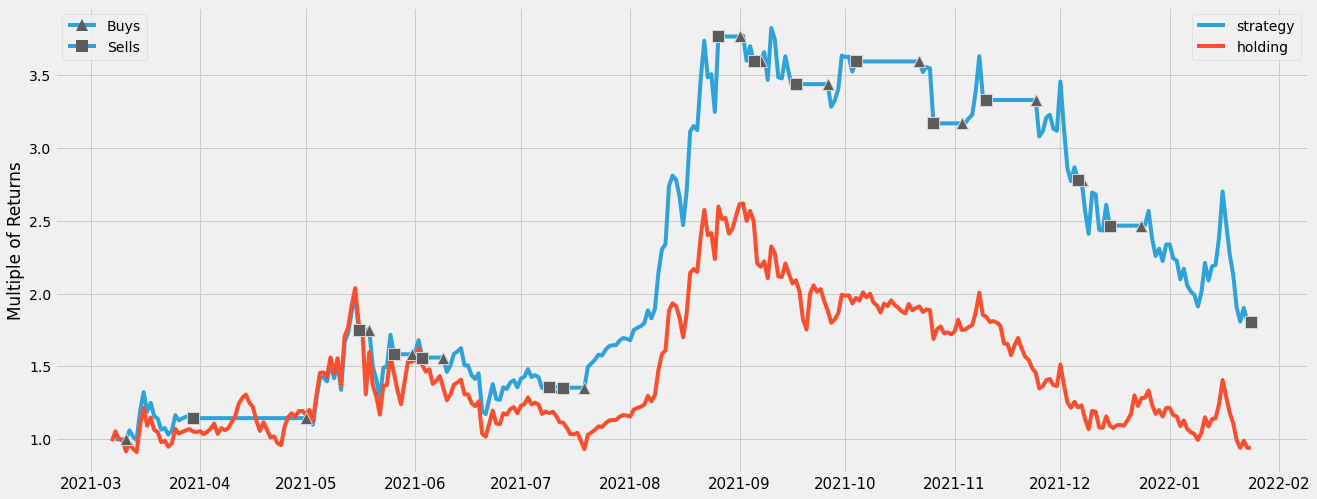

In [124]:
backtest_plotter(backtest_df, signal, backtest_lag)

In [125]:
retweets_action.append(daily_signal(backtest_df, data_type, signal, coin, ticker))

In [126]:
#Cardano Twitter Favorites
#Last tuned 1/9/2022

#This is where you specify details of the report (what API, how many lag days, moving average)
dataframe = twitter_df
data_type = 'twitter'
signal = 'favorite_count'
moving_avg = 0 #Smooths signal, takes average across specified window 
backtest_lag = 2 #Calculates predictive power into the future by lagging prices by x amount of days


#backtest variables
window = 3 #Length of days in which if signal goes up/down it would qualify as a buy/sell trigger
timeframe = 60 #How many days of past data to use to set as benchmark signal movement
buy_shift = 0.25 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift = 0.5
fee = 0.01
risk_free_rate = 0.0119

In [127]:
#Here we run the entire backtest with the above params
#We print out the returns, when tuning try to maximize this value
df = filter_df(dataframe, data_type, coin, ticker) #dataframe that goes into everything
metric_cols = metric_finder(df) #defines which columns are metrics
warnings.filterwarnings("ignore")
backtest_df = backtesting_correlation(timeframe, data_type, df, signal, window, backtest_lag, buy_shift, sell_shift, fee)
display(backtest_df)
print(backtest_df['strategy_perf'].iloc[(-1*backtest_lag) - 2])

[*********************100%***********************]  1 of 1 completed
buy: 0.05355367830950132
sell: 0.09515456502352465

buy: 0.05355367830950132
sell: 0.09515456502352465

buy: 0.05355367830950132
sell: 0.09515456502352465


date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866           0.000000   
1    2021-03-08   cardano       0.121970        0.138130           0.002000   
2    2021-03-09   cardano       0.137298        0.144704           0.004193   
3    2021-03-10   cardano       0.117404        0.155403           0.006076   
4    2021-03-11   cardano       0.129797        0.155762           0.008643   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.994340   
321  2022-01-22   cardano       0.551718        0.555283           0.995700   
322  2022-01-23   cardano       0.532558        0.531001           0.996978   
323  2022-01-24   cardano       0.270845        0.274063           0.998423   
324  2022-01-25   cardano       0.274921        0.269386           1.000000   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...     -0.555662    -0.013512  False       1.000000      1.054523  
2    ...      0.047598     0.068966  False       1.000000      1.001444  
3    ...      0.073936    -0.050838  False       1.000000      0.992432  
4    ...      0.002308    -0.009088  False       1.000000      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.031540    -0.107167   True       1.335779      0.941192  
321  ...      0.004324    -0.050316   True       1.335779      0.990298  
322  ...     -0.043729     0.052174   True            NaN      0.941088  
323  ...     -0.483876    -0.049692  False            NaN      0.941088  
324  ...     -0.017066     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866           0.000000   
1    2021-03-08   cardano       0.121970        0.138130           0.002000   
2    2021-03-09   cardano       0.137298        0.144704           0.004193   
3    2021-03-10   cardano       0.117404        0.155403           0.006076   
4    2021-03-11   cardano       0.129797        0.155762           0.008643   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.994340   
321  2022-01-22   cardano       0.551718        0.555283           0.995700   
322  2022-01-23   cardano       0.532558        0.531001           0.996978   
323  2022-01-24   cardano       0.270845        0.274063           0.998423   
324  2022-01-25   cardano       0.274921        0.269386           1.000000   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...     -0.555662    -0.013512  False       1.000000      1.054523  
2    ...      0.047598     0.068966  False       1.000000      1.001444  
3    ...      0.073936    -0.050838  False       1.000000      0.992432  
4    ...      0.002308    -0.009088  False       1.000000      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.031540    -0.107167   True       1.335779      0.941192  
321  ...      0.004324    -0.050316   True       1.335779      0.990298  
322  ...     -0.043729     0.052174   True            NaN      0.941088  
323  ...     -0.483876    -0.049692  False            NaN      0.941088  
324  ...     -0.017066     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866           0.000000   
1    2021-03-08   cardano       0.121970        0.138130           0.002000   
2    2021-03-09   cardano       0.137298        0.144704           0.004193   
3    2021-03-10   cardano       0.117404        0.155403           0.006076   
4    2021-03-11   cardano       0.129797        0.155762           0.008643   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.994340   
321  2022-01-22   cardano       0.551718        0.555283           0.995700   
322  2022-01-23   cardano       0.532558        0.531001           0.996978   
323  2022-01-24   cardano       0.270845        0.274063           0.998423   
324  2022-01-25   cardano       0.274921        0.269386           1.000000   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...     -0.555662    -0.013512  False       1.000000      1.054523  
2    ...      0.047598     0.068966  False       1.000000      1.001444  
3    ...      0.073936    -0.050838  False       1.000000      0.992432  
4    ...      0.002308    -0.009088  False       1.000000      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.031540    -0.107167   True       1.335779      0.941192  
321  ...      0.004324    -0.050316   True       1.335779      0.990298  
322  ...     -0.043729     0.052174   True            NaN      0.941088  
323  ...     -0.483876    -0.049692  False            NaN      0.941088  
324  ...     -0.017066     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

1.3357794629058837
1.3357794629058837
1.3357794629058837


In [128]:
#Calculating hit rate for tuning, try to maximize
num_trues = sum((df['Close'].diff(periods = backtest_lag) > 0) == (df[signal].diff(periods = backtest_lag) > 0))
        
hit_rate = (num_trues / len(df)) 
favorites_hitrate.append(hit_rate)
print(hit_rate)

0.5138461538461538
0.5138461538461538
0.5138461538461538


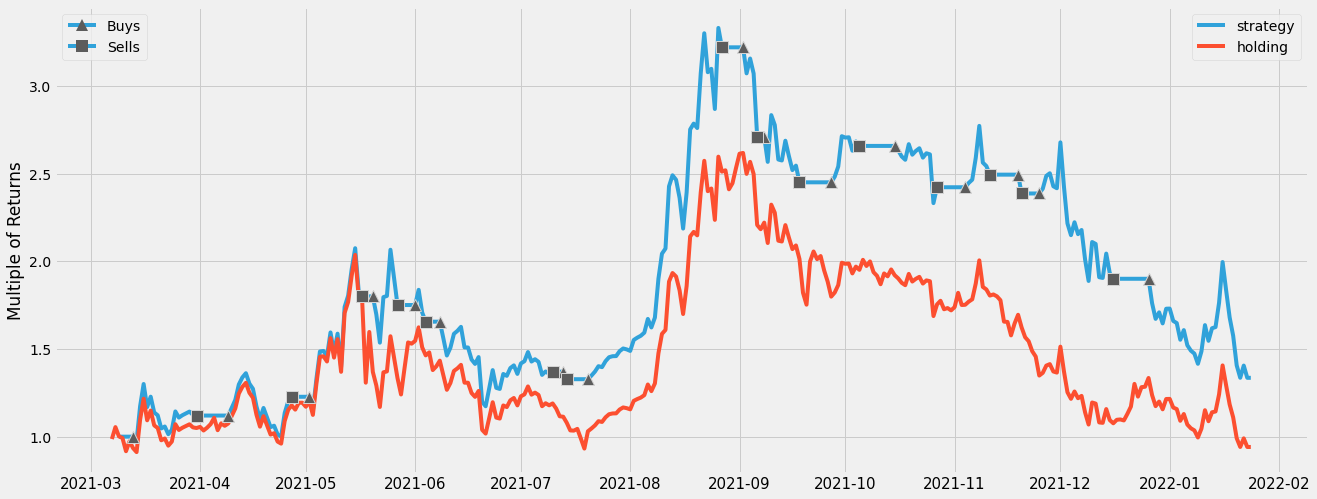

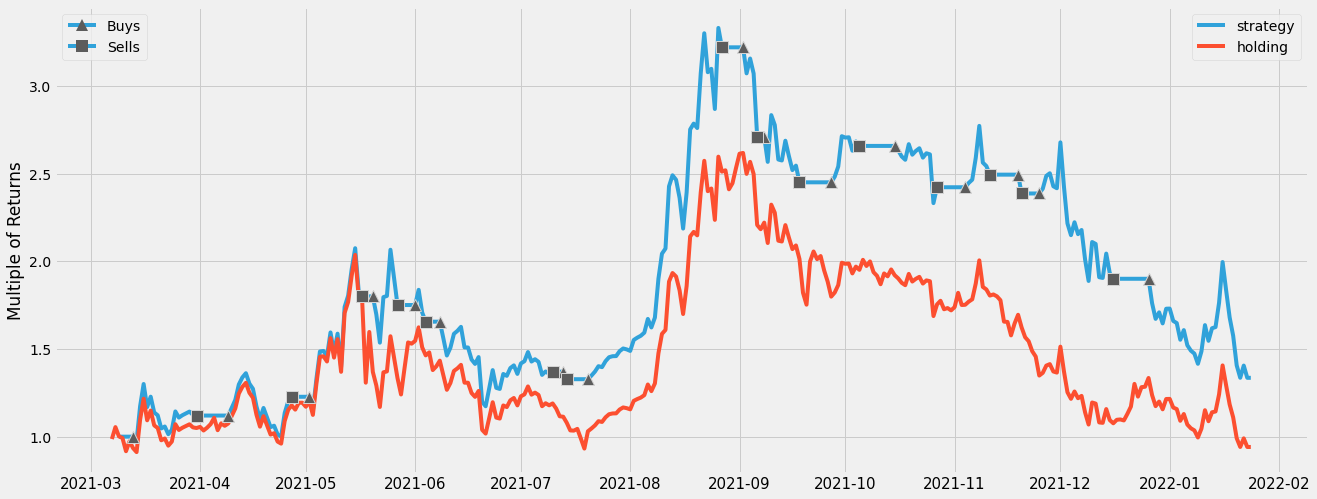

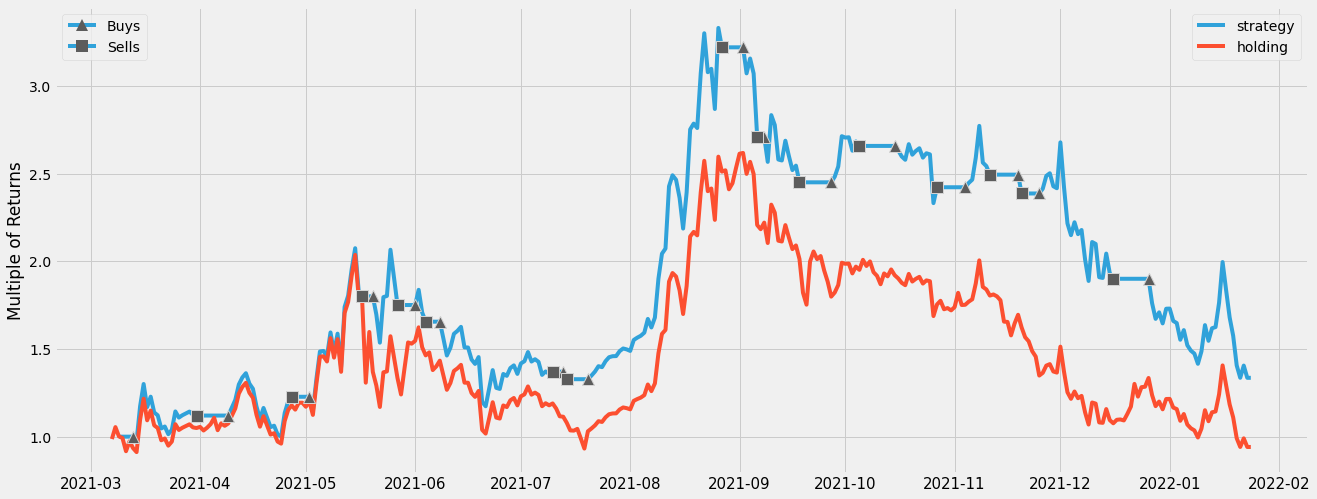

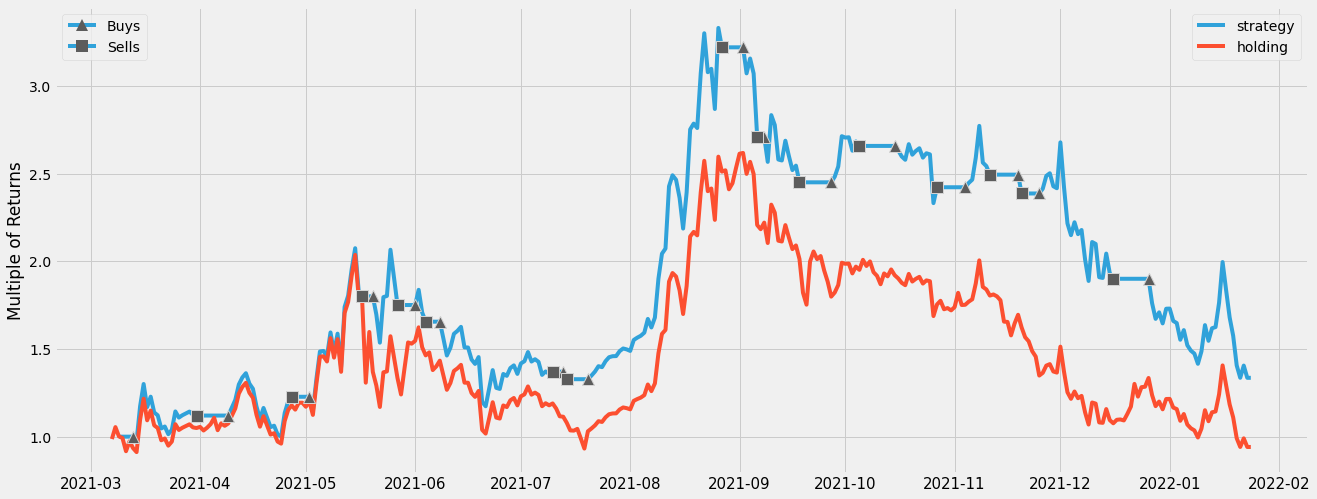

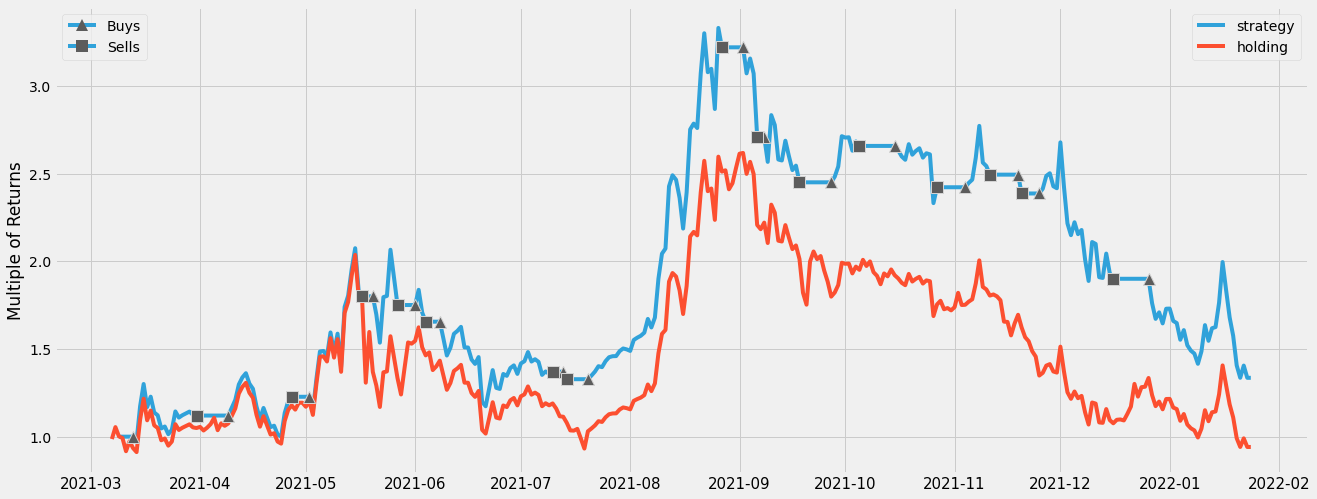

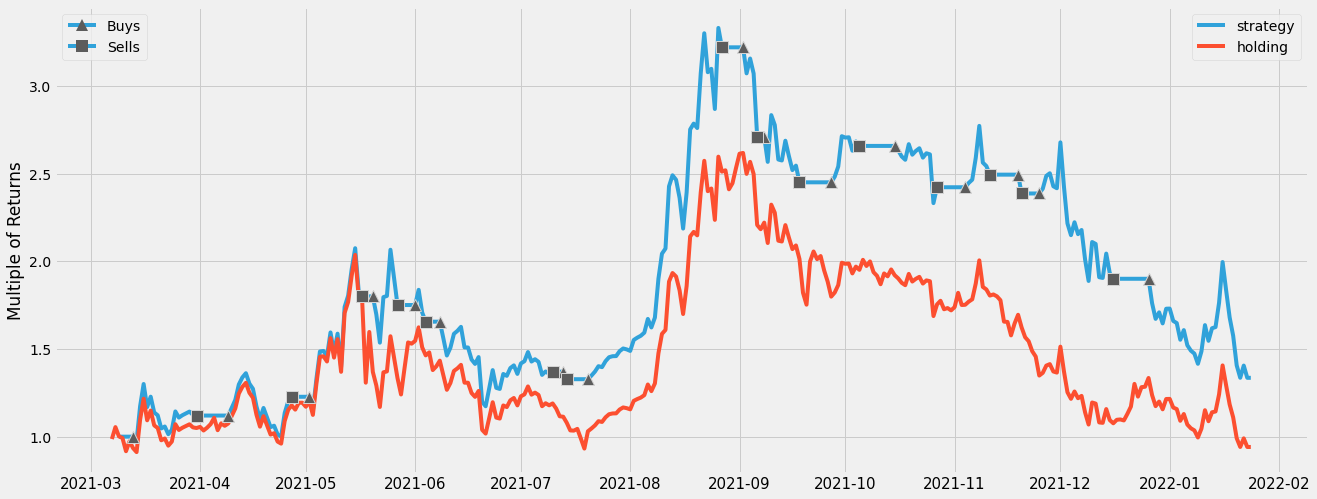

In [129]:
backtest_plotter(backtest_df, signal, backtest_lag)

In [130]:
favorites_action.append(daily_signal(backtest_df, data_type, signal, coin, ticker))

In [131]:
#Cardano Twitter Followers
#Last tuned 1/12/2022

#This is where you specify details of the report (what API, how many lag days, moving average)
dataframe = twitter_df
data_type = 'twitter'
signal = 'account_followers'
moving_avg = 0 #Smooths signal, takes average across specified window 
backtest_lag = 1 #Calculates predictive power into the future by lagging prices by x amount of days


#backtest variables
window = 3 #Length of days in which if signal goes up/down it would qualify as a buy/sell trigger
timeframe = 60 #How many days of past data to use to set as benchmark signal movement
buy_shift = 0.5 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift = 1
fee = 0.01
risk_free_rate = 0.0119

In [132]:
#Here we run the entire backtest with the above params
#We print out the returns, when tuning try to maximize this value
df = filter_df(dataframe, data_type, coin, ticker) #dataframe that goes into everything
df['account_followers'] = df['account_followers'].diff() #adjusting account_followers so it's more useful
metric_cols = metric_finder(df) #defines which columns are metrics
warnings.filterwarnings("ignore")
backtest_df = backtesting_correlation(timeframe, data_type, df, signal, window, backtest_lag, buy_shift, sell_shift, fee)
display(backtest_df)
print(backtest_df['strategy_perf'].iloc[(-1*backtest_lag) - 2])

[*********************100%***********************]  1 of 1 completed
buy: 0.00027364248730808494
sell: 0.0005763444160451539

buy: 0.00027364248730808494
sell: 0.0005763444160451539

buy: 0.00027364248730808494
sell: 0.0005763444160451539


date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866                NaN   
1    2021-03-08   cardano       0.121970        0.138130           0.498666   
2    2021-03-09   cardano       0.137298        0.144704           0.498783   
3    2021-03-10   cardano       0.117404        0.155403           0.498594   
4    2021-03-11   cardano       0.129797        0.155762           0.499012   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.498510   
321  2022-01-22   cardano       0.551718        0.555283           0.498275   
322  2022-01-23   cardano       0.532558        0.531001           0.498225   
323  2022-01-24   cardano       0.270845        0.274063           0.498326   
324  2022-01-25   cardano       0.274921        0.269386           0.498407   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...           NaN    -0.013512  False       1.000000      1.054523  
2    ...      0.000235     0.068966  False       1.000000      1.001444  
3    ...     -0.000379    -0.050335  False       1.000000      0.992432  
4    ...      0.000838    -0.008998   True       1.061753      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.000146    -0.107167  False       1.450385      0.941192  
321  ...     -0.000473    -0.050820  False       1.450385      0.990298  
322  ...     -0.000100     0.052174  False       1.450385      0.941088  
323  ...      0.000204    -0.049692  False            NaN      0.941088  
324  ...      0.000162     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866                NaN   
1    2021-03-08   cardano       0.121970        0.138130           0.498666   
2    2021-03-09   cardano       0.137298        0.144704           0.498783   
3    2021-03-10   cardano       0.117404        0.155403           0.498594   
4    2021-03-11   cardano       0.129797        0.155762           0.499012   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.498510   
321  2022-01-22   cardano       0.551718        0.555283           0.498275   
322  2022-01-23   cardano       0.532558        0.531001           0.498225   
323  2022-01-24   cardano       0.270845        0.274063           0.498326   
324  2022-01-25   cardano       0.274921        0.269386           0.498407   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...           NaN    -0.013512  False       1.000000      1.054523  
2    ...      0.000235     0.068966  False       1.000000      1.001444  
3    ...     -0.000379    -0.050335  False       1.000000      0.992432  
4    ...      0.000838    -0.008998   True       1.061753      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.000146    -0.107167  False       1.450385      0.941192  
321  ...     -0.000473    -0.050820  False       1.450385      0.990298  
322  ...     -0.000100     0.052174  False       1.450385      0.941088  
323  ...      0.000204    -0.049692  False            NaN      0.941088  
324  ...      0.000162     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape user_name  retweet_count  favorite_count  account_followers  \
0    2021-03-07   cardano       0.299054        0.310866                NaN   
1    2021-03-08   cardano       0.121970        0.138130           0.498666   
2    2021-03-09   cardano       0.137298        0.144704           0.498783   
3    2021-03-10   cardano       0.117404        0.155403           0.498594   
4    2021-03-11   cardano       0.129797        0.155762           0.499012   
..          ...       ...            ...             ...                ...   
320  2022-01-21   cardano       0.547641        0.552892           0.498510   
321  2022-01-22   cardano       0.551718        0.555283           0.498275   
322  2022-01-23   cardano       0.532558        0.531001           0.498225   
323  2022-01-24   cardano       0.270845        0.274063           0.498326   
324  2022-01-25   cardano       0.274921        0.269386           0.498407   

     ...  sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0    ...           NaN          NaN  False       1.000000      0.986488  
1    ...           NaN    -0.013512  False       1.000000      1.054523  
2    ...      0.000235     0.068966  False       1.000000      1.001444  
3    ...     -0.000379    -0.050335  False       1.000000      0.992432  
4    ...      0.000838    -0.008998   True       1.061753      0.916865  
..   ...           ...          ...    ...            ...           ...  
320  ...     -0.000146    -0.107167  False       1.450385      0.941192  
321  ...     -0.000473    -0.050820  False       1.450385      0.990298  
322  ...     -0.000100     0.052174  False       1.450385      0.941088  
323  ...      0.000204    -0.049692  False            NaN      0.941088  
324  ...      0.000162     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

1.4503853682188361
1.4503853682188361
1.4503853682188361


In [133]:
#Calculating hit rate for tuning, try to maximize
num_trues = sum((df['Close'].diff(periods = backtest_lag) > 0) == (df[signal].diff(periods = backtest_lag) > 0))
        
hit_rate = (num_trues / len(df)) 
followers_hitrate.append(hit_rate)
print(hit_rate)

0.5907692307692308
0.5907692307692308
0.5907692307692308


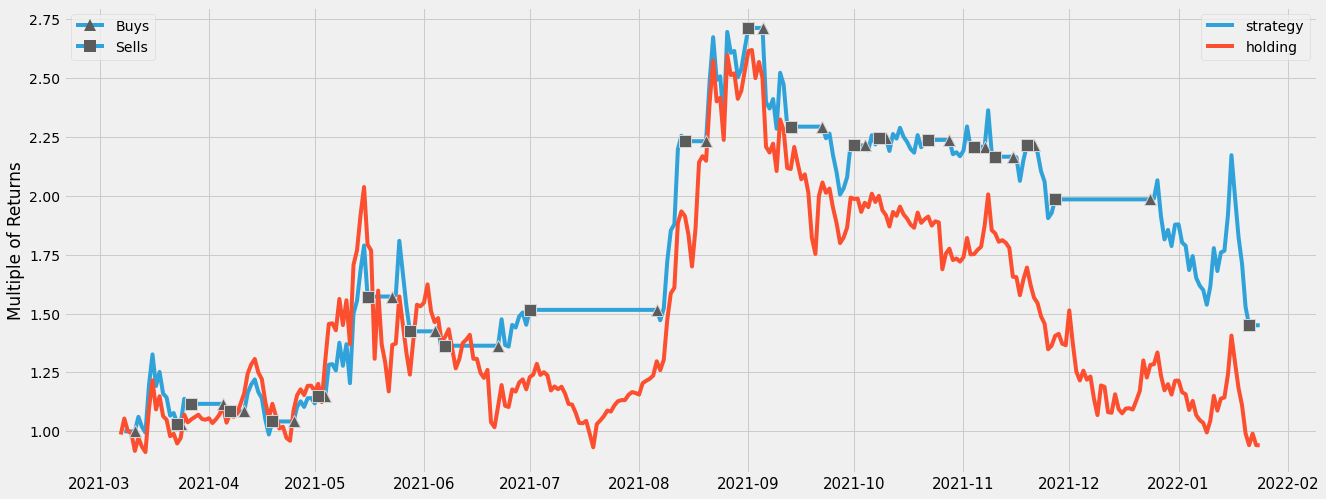

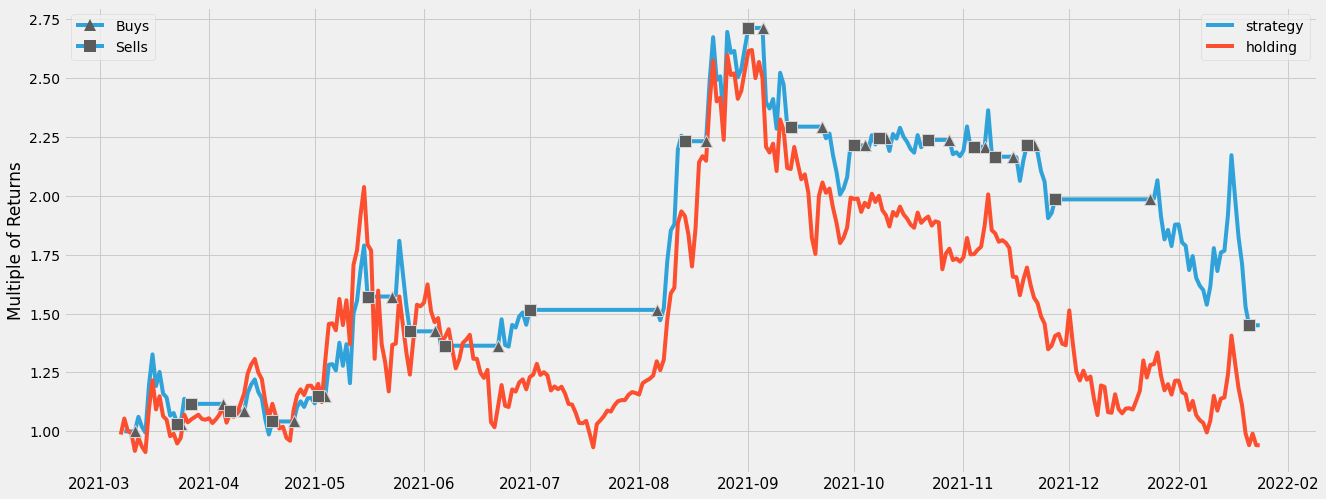

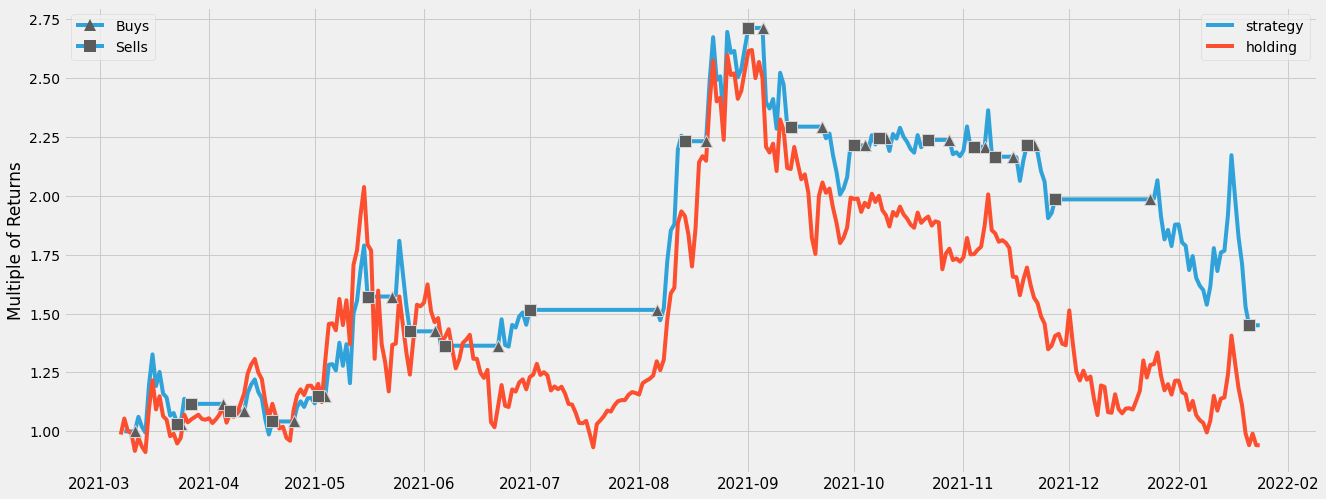

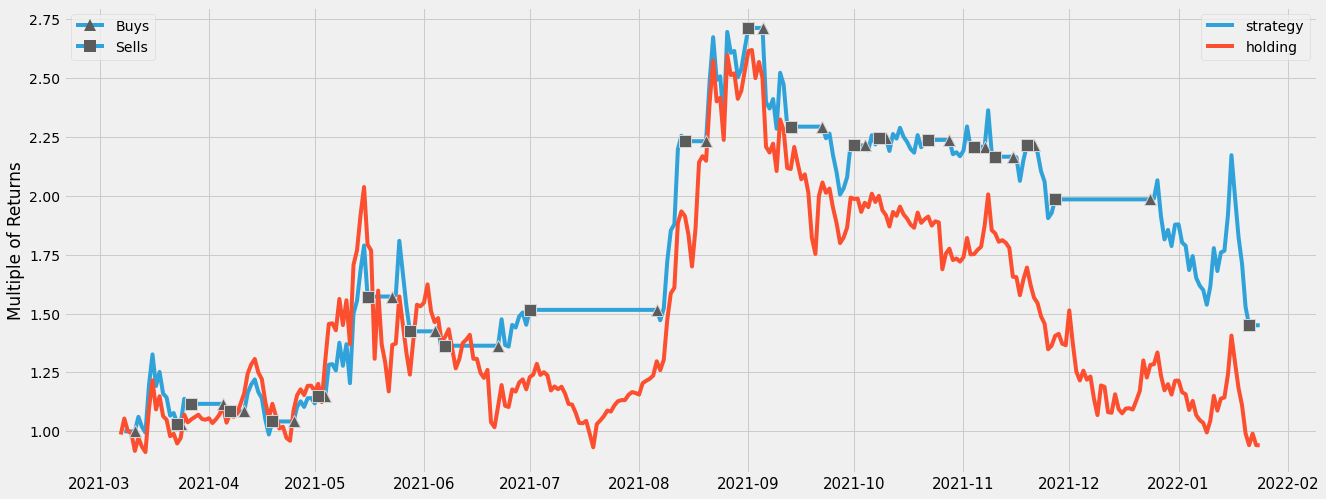

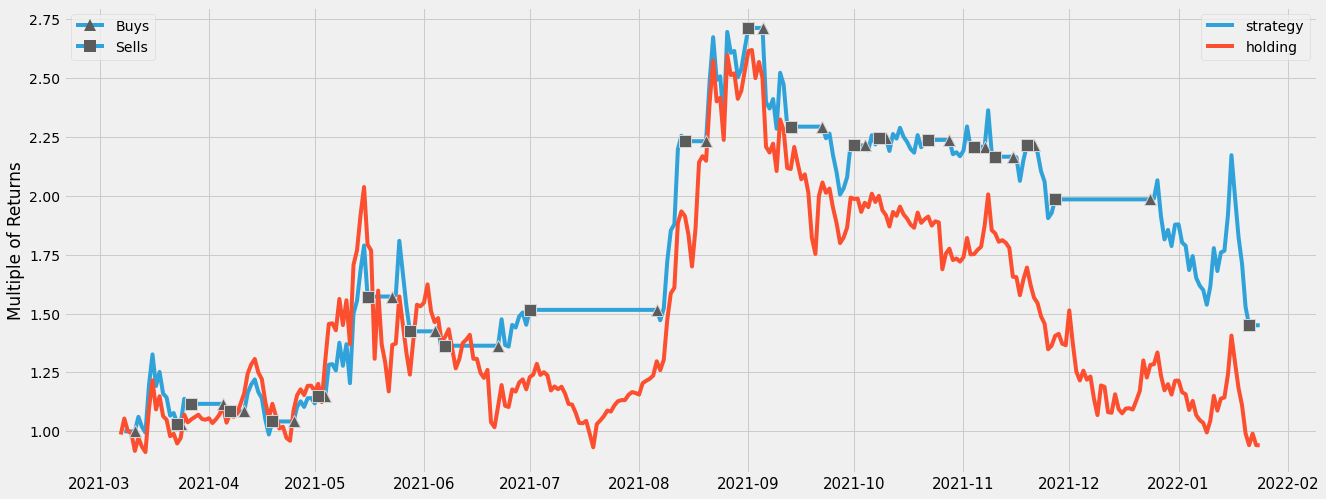

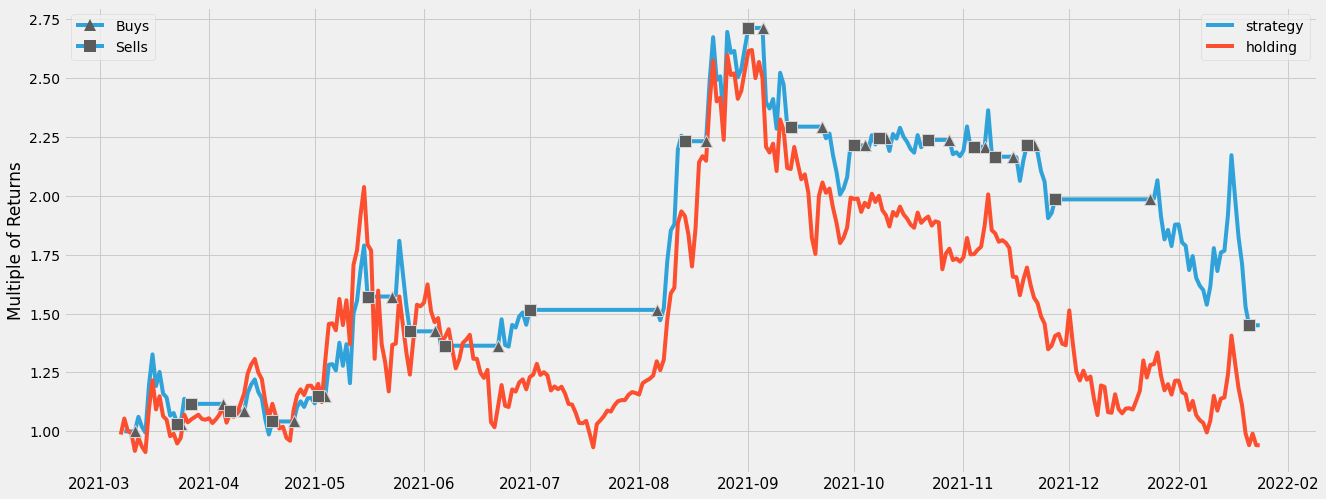

In [134]:
backtest_plotter(backtest_df, signal, backtest_lag)

In [135]:
followers_action.append(daily_signal(backtest_df, data_type, signal, coin, ticker))

## Reddit

In [136]:
#Cardano Reddit Comments
#Last tuned 1/12/2022

#This is where you specify details of the report (what API, how many lag days, moving average)
dataframe = reddit_df
data_type = 'reddit'
signal = 'num_comms'
moving_avg = 0 #Smooths signal, takes average across specified window 
backtest_lag = 5 #Calculates predictive power into the future by lagging prices by x amount of days


#backtest variables
window = 3 #Length of days in which if signal goes up/down it would qualify as a buy/sell trigger
timeframe = 60 #How many days of past data to use to set as benchmark signal movement
buy_shift = 1.5 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift = 1.5
fee = 0.01
risk_free_rate = 0.0119

In [137]:
#Here we run the entire backtest with the above params
#We print out the returns, when tuning try to maximize this value
df = filter_df(dataframe, data_type, coin, ticker) #dataframe that goes into everything
metric_cols = metric_finder(df) #defines which columns are metrics
warnings.filterwarnings("ignore")
backtest_df = backtesting_correlation(timeframe, data_type, df, signal, window, backtest_lag, buy_shift, sell_shift, fee)
display(backtest_df)
print(backtest_df['strategy_perf'].iloc[(-1*backtest_lag) - 2])

[*********************100%***********************]  1 of 1 completed
buy: 0.026245683289053565
sell: 0.026245683289053565

buy: 0.026245683289053565
sell: 0.026245683289053565


date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano        0.000000   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.004065   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.007730   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.996727   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.997637   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.998590   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.999403   0.427295  0.000866  ...   
324  2022-01-25   cardano        1.000000   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False       1.000000      0.986488  
1        0.019680    -0.013512  False       1.000000      1.054523  
2        0.007671     0.068966   True       0.975816      1.001444  
3        0.005095    -0.050335   True       1.173534      0.992432  
4        0.015636    -0.008998   True       1.300392      0.916865  
..            ...          ...    ...            ...           ...  
320      0.004475    -0.107167  False            NaN      0.941192  
321      0.029535    -0.050820  False            NaN      0.990298  
322      0.019675     0.052174  False            NaN      0.941088  
323      0.014877    -0.049692   True            NaN      0.941088  
324      0.009269     0.000000   True            NaN           NaN  

[325 rows x 12 columns]

date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano        0.000000   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.004065   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.007730   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.996727   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.997637   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.998590   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.999403   0.427295  0.000866  ...   
324  2022-01-25   cardano        1.000000   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False       1.000000      0.986488  
1        0.019680    -0.013512  False       1.000000      1.054523  
2        0.007671     0.068966   True       0.975816      1.001444  
3        0.005095    -0.050335   True       1.173534      0.992432  
4        0.015636    -0.008998   True       1.300392      0.916865  
..            ...          ...    ...            ...           ...  
320      0.004475    -0.107167  False            NaN      0.941192  
321      0.029535    -0.050820  False            NaN      0.990298  
322      0.019675     0.052174  False            NaN      0.941088  
323      0.014877    -0.049692   True            NaN      0.941088  
324      0.009269     0.000000   True            NaN           NaN  

[325 rows x 12 columns]


buy: 0.026245683289053565
sell: 0.026245683289053565
1.4281852454492543
1.4281852454492543


date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano        0.000000   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.004065   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.007730   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.996727   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.997637   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.998590   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.999403   0.427295  0.000866  ...   
324  2022-01-25   cardano        1.000000   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False       1.000000      0.986488  
1        0.019680    -0.013512  False       1.000000      1.054523  
2        0.007671     0.068966   True       0.975816      1.001444  
3        0.005095    -0.050335   True       1.173534      0.992432  
4        0.015636    -0.008998   True       1.300392      0.916865  
..            ...          ...    ...            ...           ...  
320      0.004475    -0.107167  False            NaN      0.941192  
321      0.029535    -0.050820  False            NaN      0.990298  
322      0.019675     0.052174  False            NaN      0.941088  
323      0.014877    -0.049692   True            NaN      0.941088  
324      0.009269     0.000000   True            NaN           NaN  

[325 rows x 12 columns]

1.4281852454492543


In [138]:
#Calculating hit rate for tuning, try to maximize
num_trues = sum((df['Close'].diff(periods = backtest_lag) > 0) == (df[signal].diff(periods = backtest_lag) > 0))
        
hit_rate = (num_trues / len(df)) 
num_comms_hitrate.append(hit_rate)
print(hit_rate)

0.46153846153846156
0.46153846153846156
0.46153846153846156


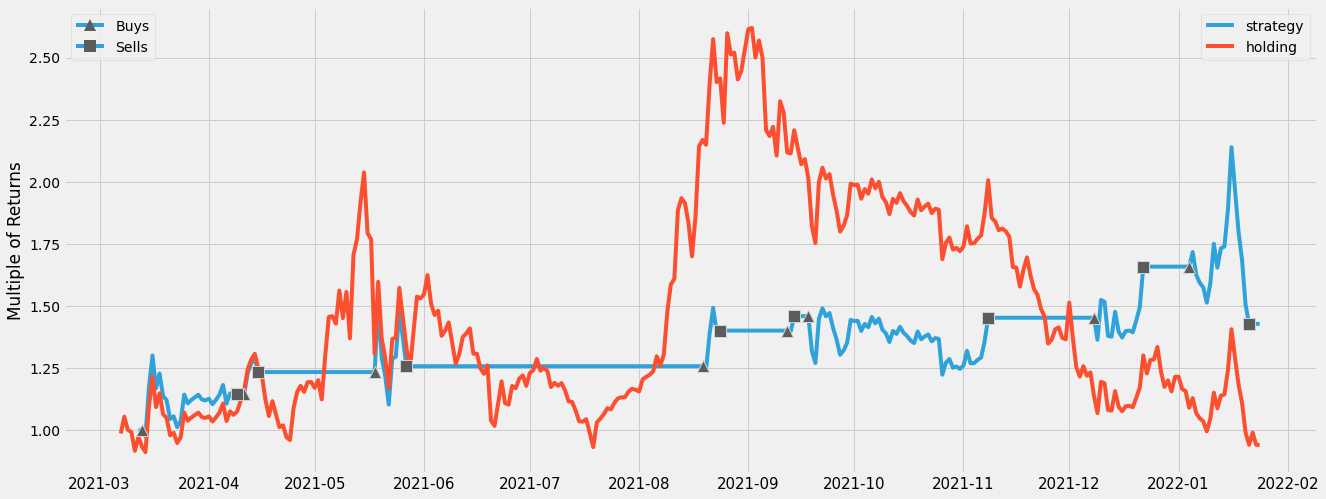

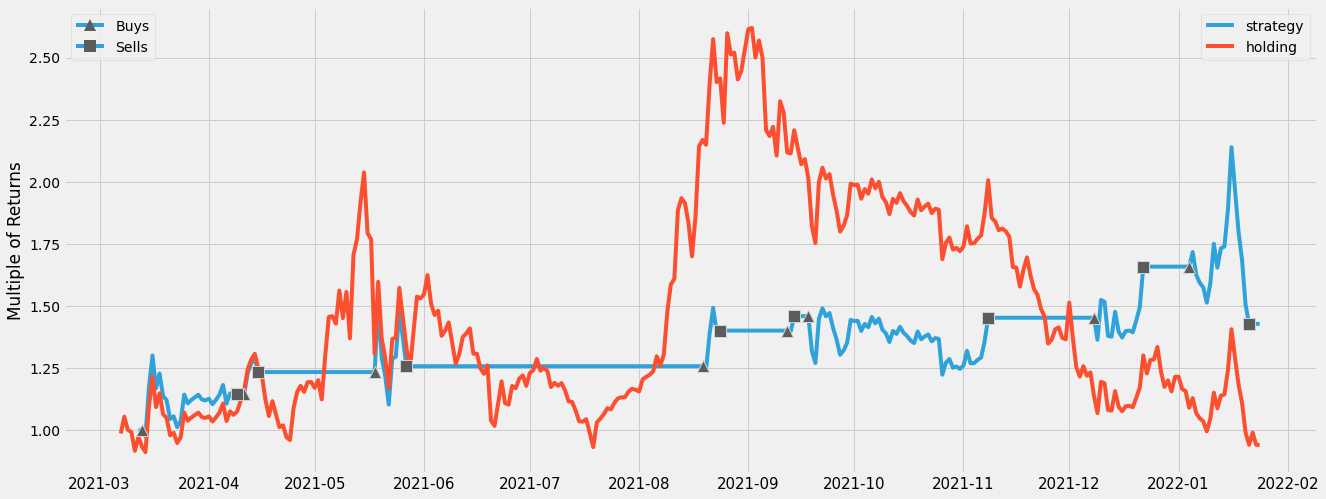

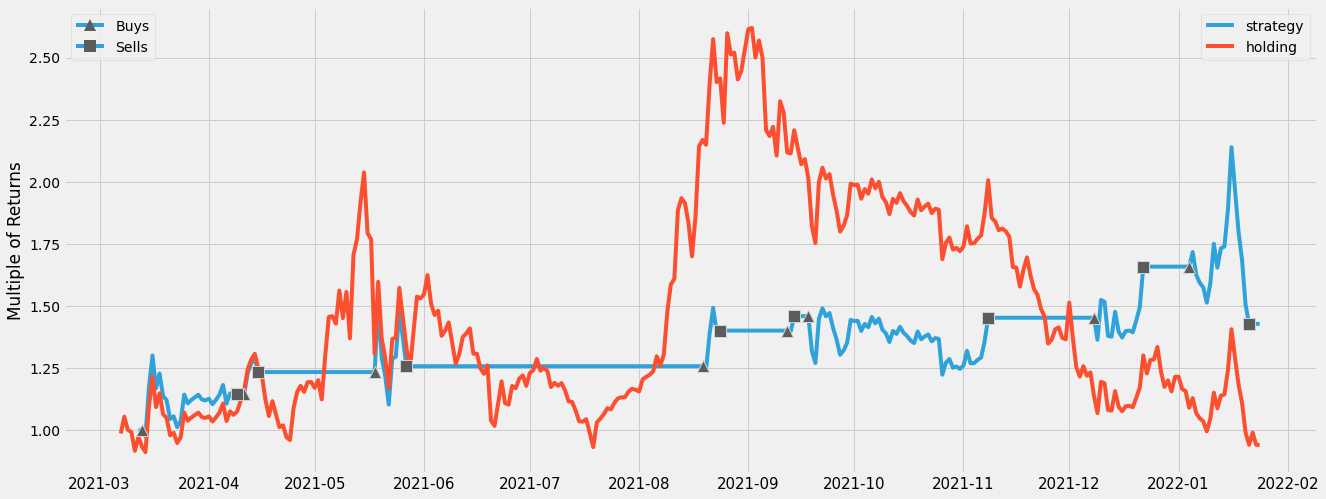

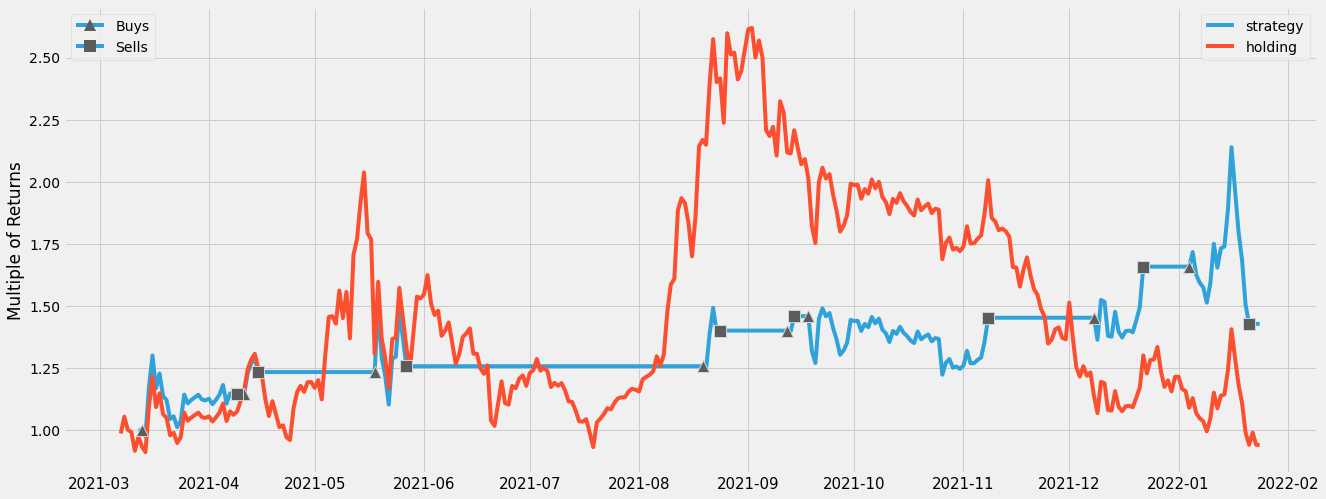

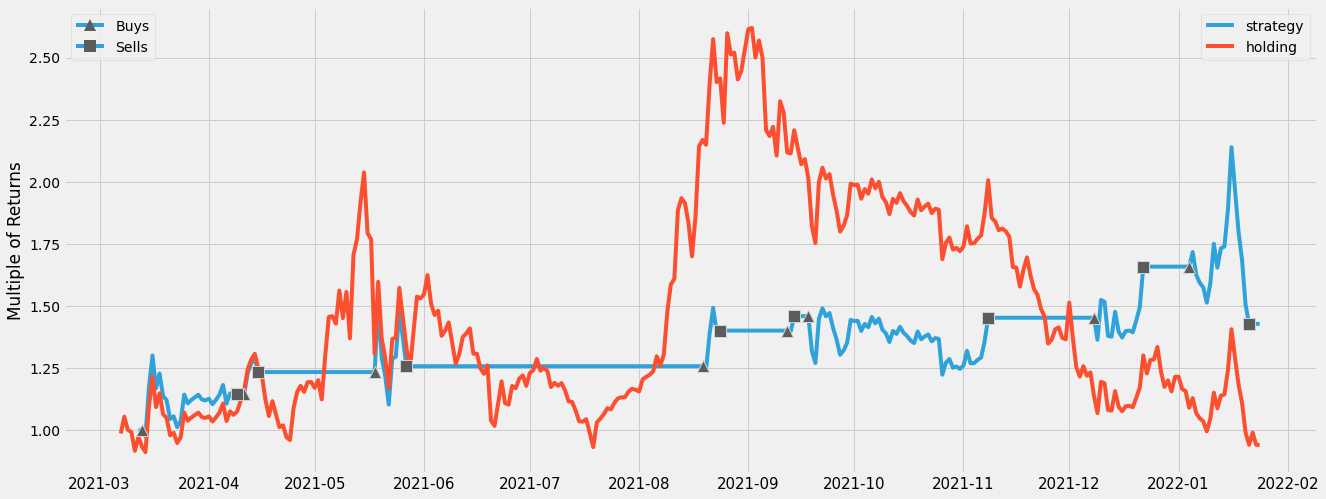

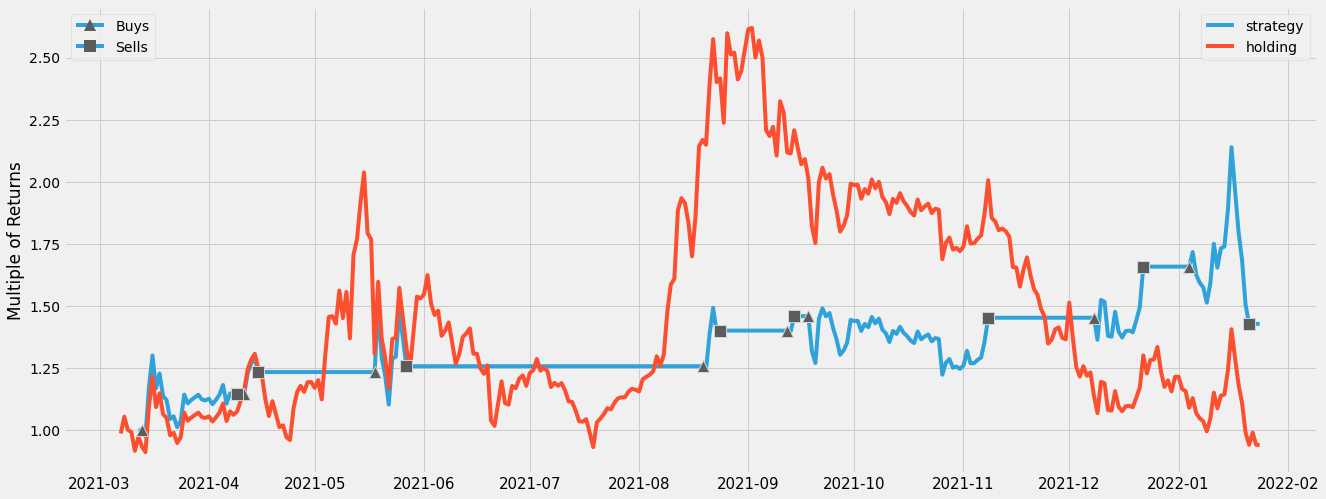

In [139]:
backtest_plotter(backtest_df, signal, backtest_lag)

In [140]:
num_comms_action.append(daily_signal(backtest_df, data_type, signal, coin, ticker))

In [141]:
#Cardano Reddit Score
#Last tuned 1/12/2022

#This is where you specify details of the report (what API, how many lag days, moving average)
dataframe = reddit_df
data_type = 'reddit'
signal = 'score'
moving_avg = 0 #Smooths signal, takes average across specified window 
backtest_lag = 5 #Calculates predictive power into the future by lagging prices by x amount of days


#backtest variables
window = 3 #Length of days in which if signal goes up/down it would qualify as a buy/sell trigger
timeframe = 60 #How many days of past data to use to set as benchmark signal movement
buy_shift = 1 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift = 1
fee = 0.01
risk_free_rate = 0.0119

In [142]:
#Here we run the entire backtest with the above params
#We print out the returns, when tuning try to maximize this value
df = filter_df(dataframe, data_type, coin, ticker) #dataframe that goes into everything
metric_cols = metric_finder(df) #defines which columns are metrics
warnings.filterwarnings("ignore")
backtest_df = backtesting_correlation(timeframe, data_type, df, signal, window, backtest_lag, buy_shift, sell_shift, fee)
display(backtest_df)
print(backtest_df['strategy_perf'].iloc[(-1*backtest_lag) - 2])

[*********************100%***********************]  1 of 1 completed
buy: 0.2327930354806531
sell: 0.2327930354806531

buy: 0.2327930354806531
sell: 0.2327930354806531

buy: 0.2327930354806531
sell: 0.2327930354806531


date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano        0.000000   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.004065   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.007730   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.996727   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.997637   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.998590   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.999403   0.427295  0.000866  ...   
324  2022-01-25   cardano        1.000000   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False            1.0      0.986488  
1        0.011275    -0.013512  False            1.0      1.054523  
2        0.041098     0.068966  False            1.0      1.001444  
3        0.053976    -0.050335  False            1.0      0.992432  
4        0.046620    -0.008998  False            1.0      0.916865  
..            ...          ...    ...            ...           ...  
320     -1.000000    -0.107167  False            NaN      0.941192  
321           inf    -0.050820  False            NaN      0.990298  
322     -0.885912     0.052174  False            NaN      0.941088  
323      0.750000    -0.049692  False            NaN      0.941088  
324      1.134199     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano        0.000000   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.004065   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.007730   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.996727   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.997637   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.998590   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.999403   0.427295  0.000866  ...   
324  2022-01-25   cardano        1.000000   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False            1.0      0.986488  
1        0.011275    -0.013512  False            1.0      1.054523  
2        0.041098     0.068966  False            1.0      1.001444  
3        0.053976    -0.050335  False            1.0      0.992432  
4        0.046620    -0.008998  False            1.0      0.916865  
..            ...          ...    ...            ...           ...  
320     -1.000000    -0.107167  False            NaN      0.941192  
321           inf    -0.050820  False            NaN      0.990298  
322     -0.885912     0.052174  False            NaN      0.941088  
323      0.750000    -0.049692  False            NaN      0.941088  
324      1.134199     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano        0.000000   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.004065   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.007730   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.996727   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.997637   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.998590   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.999403   0.427295  0.000866  ...   
324  2022-01-25   cardano        1.000000   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False            1.0      0.986488  
1        0.011275    -0.013512  False            1.0      1.054523  
2        0.041098     0.068966  False            1.0      1.001444  
3        0.053976    -0.050335  False            1.0      0.992432  
4        0.046620    -0.008998  False            1.0      0.916865  
..            ...          ...    ...            ...           ...  
320     -1.000000    -0.107167  False            NaN      0.941192  
321           inf    -0.050820  False            NaN      0.990298  
322     -0.885912     0.052174  False            NaN      0.941088  
323      0.750000    -0.049692  False            NaN      0.941088  
324      1.134199     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

1.0753848641801451
1.0753848641801451
1.0753848641801451


In [143]:
#Calculating hit rate for tuning, try to maximize
num_trues = sum((df['Close'].diff(periods = backtest_lag) > 0) == (df[signal].diff(periods = backtest_lag) > 0))
        
hit_rate = (num_trues / len(df)) 
score_hitrate.append(hit_rate)
print(hit_rate)

0.5476923076923077
0.5476923076923077
0.5476923076923077


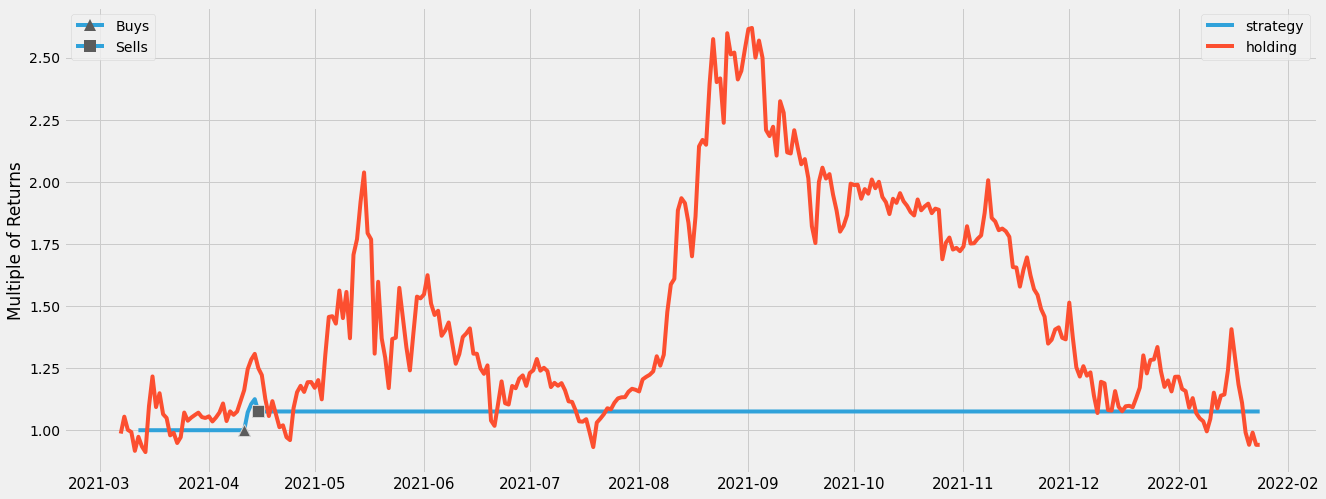

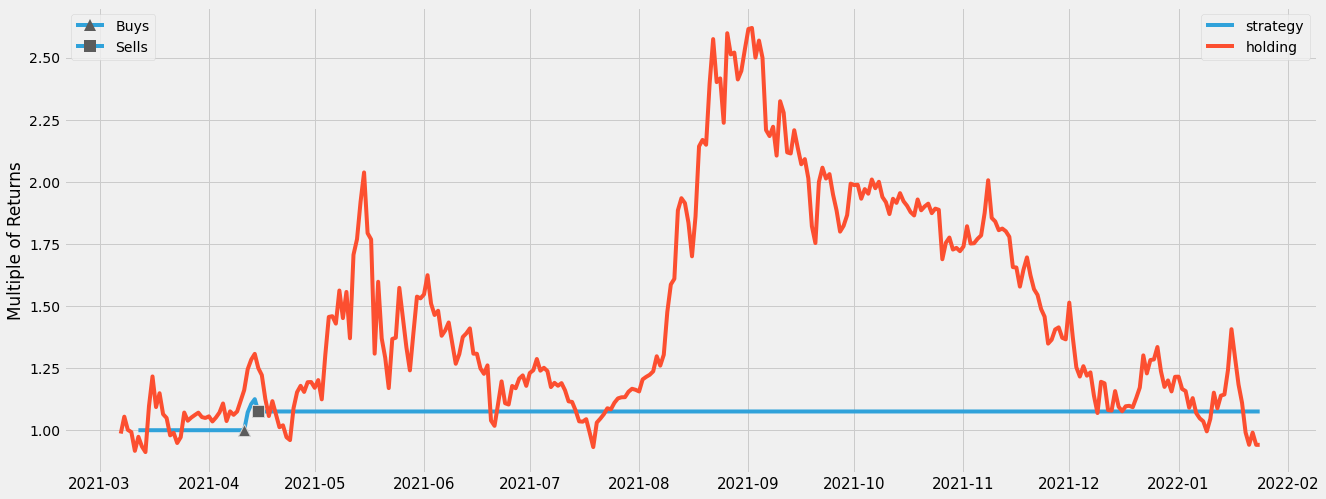

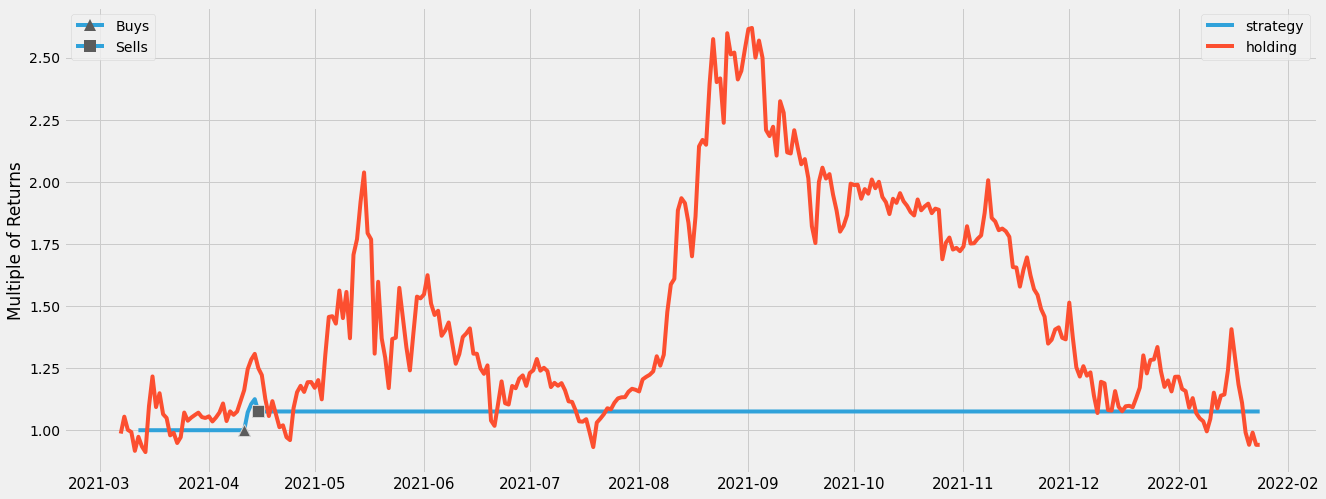

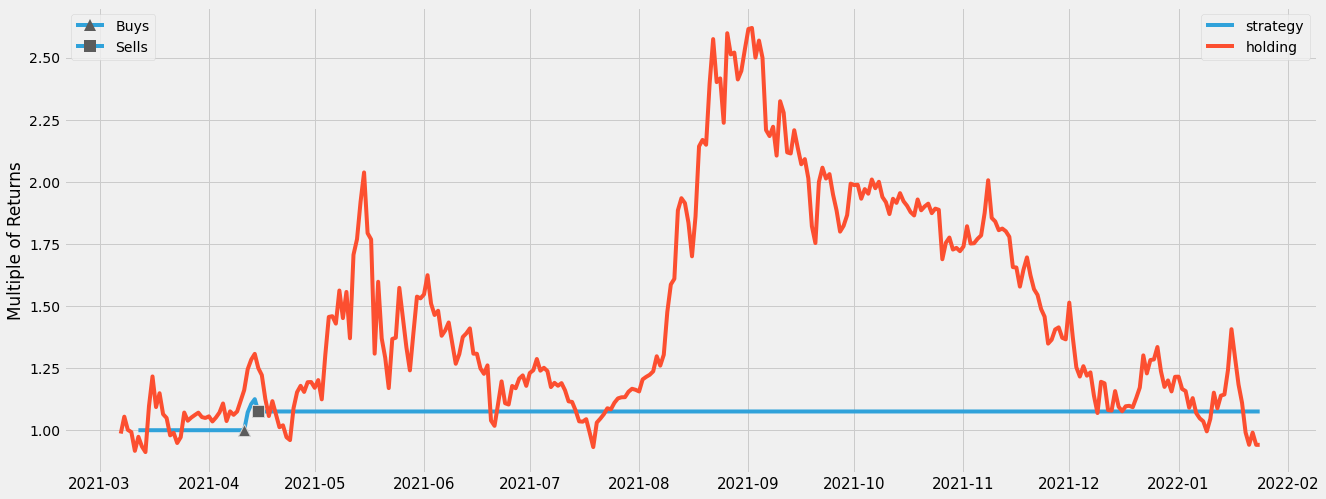

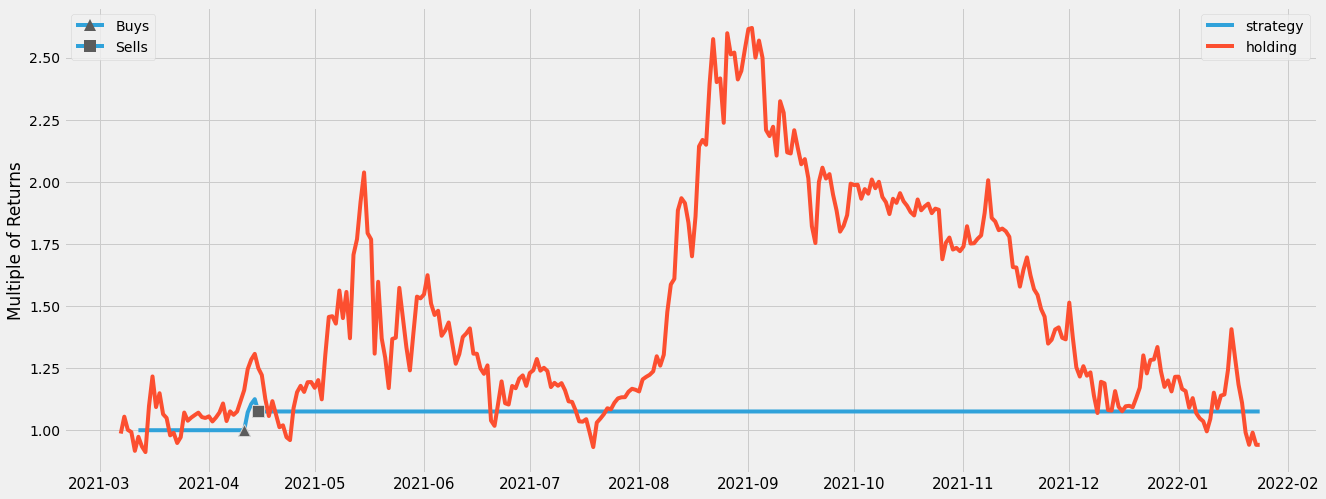

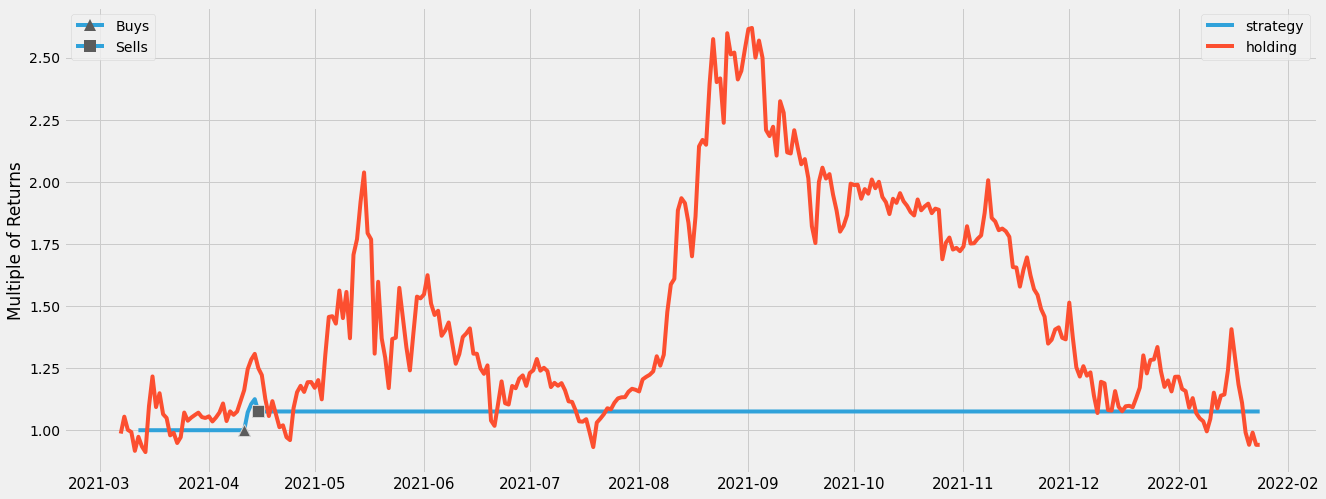

In [144]:
backtest_plotter(backtest_df, signal, backtest_lag)

In [145]:
score_action.append(daily_signal(backtest_df, data_type, signal, coin, ticker))

In [146]:
#Cardano Reddit Subscribers
#Last tuned 1/12/2022

#This is where you specify details of the report (what API, how many lag days, moving average)
dataframe = reddit_df
data_type = 'reddit'
signal = 'subreddit_subs'
moving_avg = 0 #Smooths signal, takes average across specified window 
backtest_lag = 1 #Calculates predictive power into the future by lagging prices by x amount of days


#backtest variables
window = 3 #Length of days in which if signal goes up/down it would qualify as a buy/sell trigger
timeframe = 60 #How many days of past data to use to set as benchmark signal movement
buy_shift = 1.25 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift = 1.5
fee = 0.01
risk_free_rate = 0.0119

In [147]:
#Here we run the entire backtest with the above params
#We print out the returns, when tuning try to maximize this value
df = filter_df(dataframe, data_type, coin, ticker) #dataframe that goes into everything
df['subreddit_subs'] = df['subreddit_subs'].diff() #adjusting account_followers so it's more useful
metric_cols = metric_finder(df) #defines which columns are metrics
warnings.filterwarnings("ignore")
backtest_df = backtesting_correlation(timeframe, data_type, df, signal, window, backtest_lag, buy_shift, sell_shift, fee)
display(backtest_df)
print(backtest_df['strategy_perf'].iloc[(-1*backtest_lag) - 2])

[*********************100%***********************]  1 of 1 completed
buy: 0.0003148681243814956
sell: 0.00037972622173411326

buy: 0.0003148681243814956
sell: 0.00037972622173411326

buy: 0.0003148681243814956
sell: 0.00037972622173411326


date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano             NaN   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.498638   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.498368   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.496404   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.496501   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.496530   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.496435   0.427295  0.000866  ...   
324  2022-01-25   cardano        0.496289   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False       1.000000      0.986488  
1             NaN    -0.013512  False       1.000000      1.054523  
2             NaN     0.068966  False       1.000000      1.001444  
3             NaN    -0.050335  False       1.000000      0.992432  
4       -0.000543    -0.008998  False       1.000000      0.916865  
..            ...          ...    ...            ...           ...  
320     -0.000373    -0.107167  False       1.538033      0.941192  
321      0.000194    -0.050820  False       1.538033      0.990298  
322      0.000060     0.052174  False       1.538033      0.941088  
323     -0.000191    -0.049692  False            NaN      0.941088  
324     -0.000295     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano             NaN   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.498638   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.498368   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.496404   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.496501   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.496530   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.496435   0.427295  0.000866  ...   
324  2022-01-25   cardano        0.496289   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False       1.000000      0.986488  
1             NaN    -0.013512  False       1.000000      1.054523  
2             NaN     0.068966  False       1.000000      1.001444  
3             NaN    -0.050335  False       1.000000      0.992432  
4       -0.000543    -0.008998  False       1.000000      0.916865  
..            ...          ...    ...            ...           ...  
320     -0.000373    -0.107167  False       1.538033      0.941192  
321      0.000194    -0.050820  False       1.538033      0.990298  
322      0.000060     0.052174  False       1.538033      0.941088  
323     -0.000191    -0.049692  False            NaN      0.941088  
324     -0.000295     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

date_scrape subreddit  subreddit_subs  num_comms     score  ...  \
0    2021-03-07   cardano             NaN   0.579444  0.181777  ...   
1    2021-03-08   cardano             NaN   0.590847  0.183827  ...   
2    2021-03-09   cardano             NaN   0.595379  0.191382  ...   
3    2021-03-10   cardano        0.498638   0.598413  0.201712  ...   
4    2021-03-11   cardano        0.498368   0.607770  0.211116  ...   
..          ...       ...             ...        ...       ...  ...   
320  2022-01-21   cardano        0.496404   0.401062  0.000000  ...   
321  2022-01-22   cardano        0.496501   0.412908  0.004339  ...   
322  2022-01-23   cardano        0.496530   0.421032  0.000495  ...   
323  2022-01-24   cardano        0.496435   0.427295  0.000866  ...   
324  2022-01-25   cardano        0.496289   0.431256  0.001849  ...   

     sig_movement  fee_returns   hold  strategy_perf  holding_perf  
0             NaN          NaN  False       1.000000      0.986488  
1             NaN    -0.013512  False       1.000000      1.054523  
2             NaN     0.068966  False       1.000000      1.001444  
3             NaN    -0.050335  False       1.000000      0.992432  
4       -0.000543    -0.008998  False       1.000000      0.916865  
..            ...          ...    ...            ...           ...  
320     -0.000373    -0.107167  False       1.538033      0.941192  
321      0.000194    -0.050820  False       1.538033      0.990298  
322      0.000060     0.052174  False       1.538033      0.941088  
323     -0.000191    -0.049692  False            NaN      0.941088  
324     -0.000295     0.000000  False            NaN           NaN  

[325 rows x 12 columns]

1.5380329444675562
1.5380329444675562
1.5380329444675562


In [148]:
#Calculating hit rate for tuning, try to maximize
num_trues = sum((df['Close'].diff(periods = backtest_lag) > 0) == (df[signal].diff(periods = backtest_lag) > 0))
        
hit_rate = (num_trues / len(df)) 
subs_hitrate.append(hit_rate)
print(hit_rate)

0.5692307692307692
0.5692307692307692
0.5692307692307692


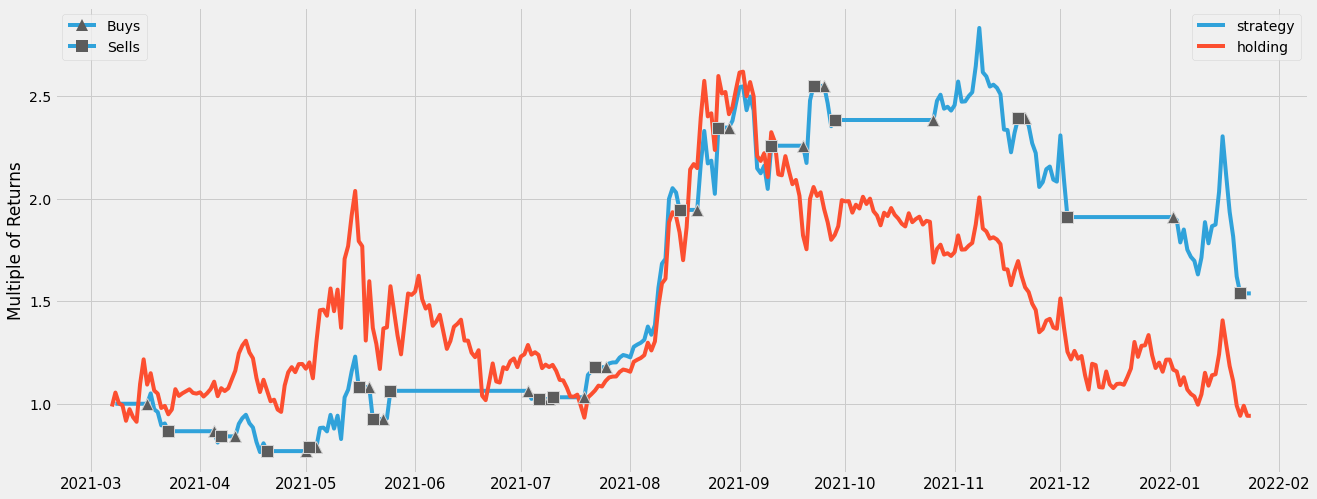

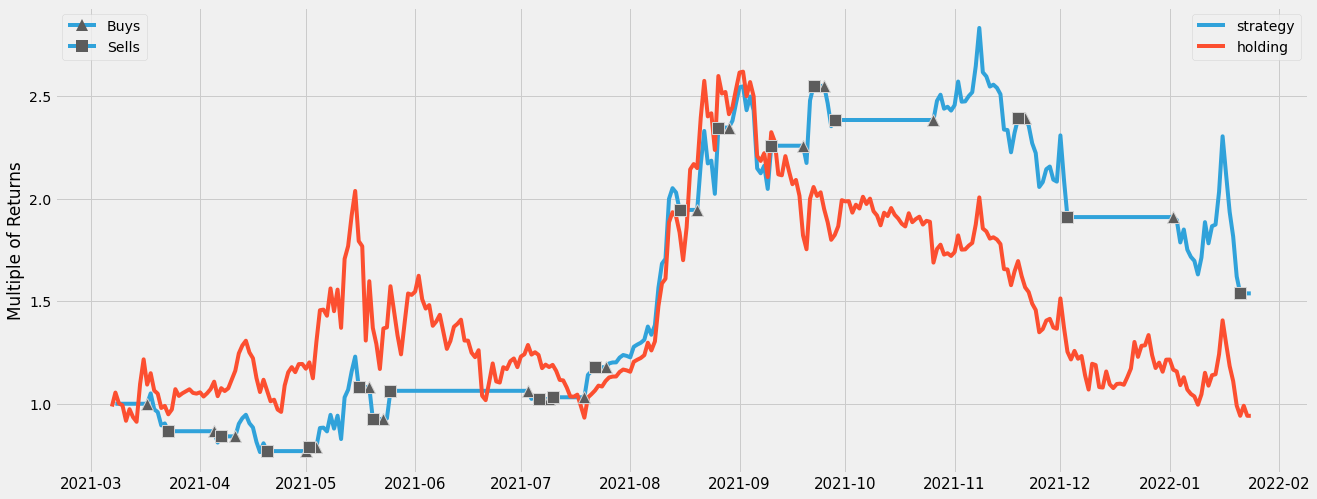

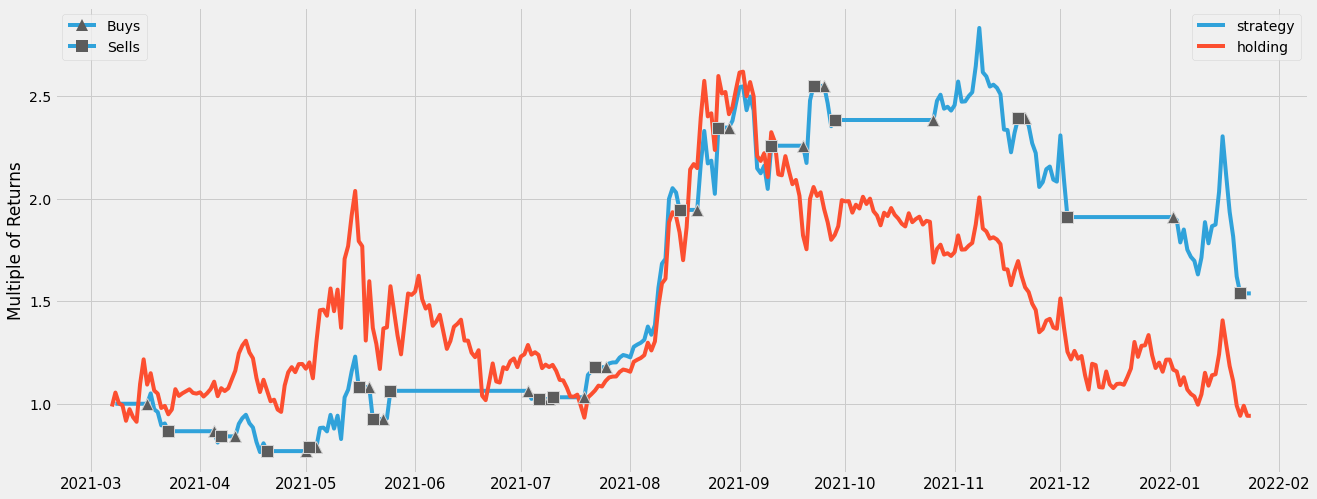

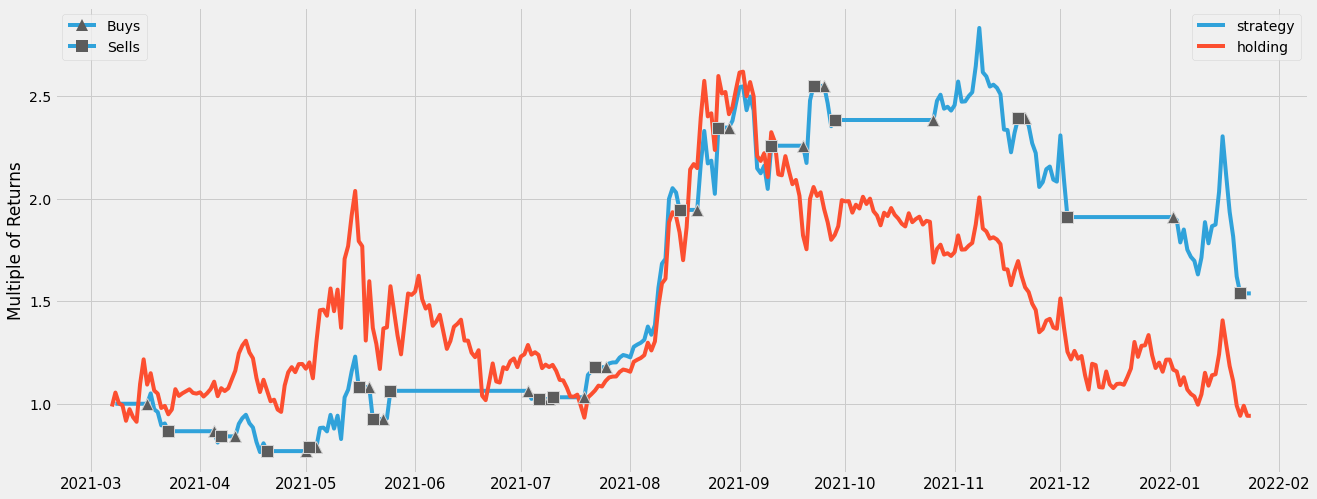

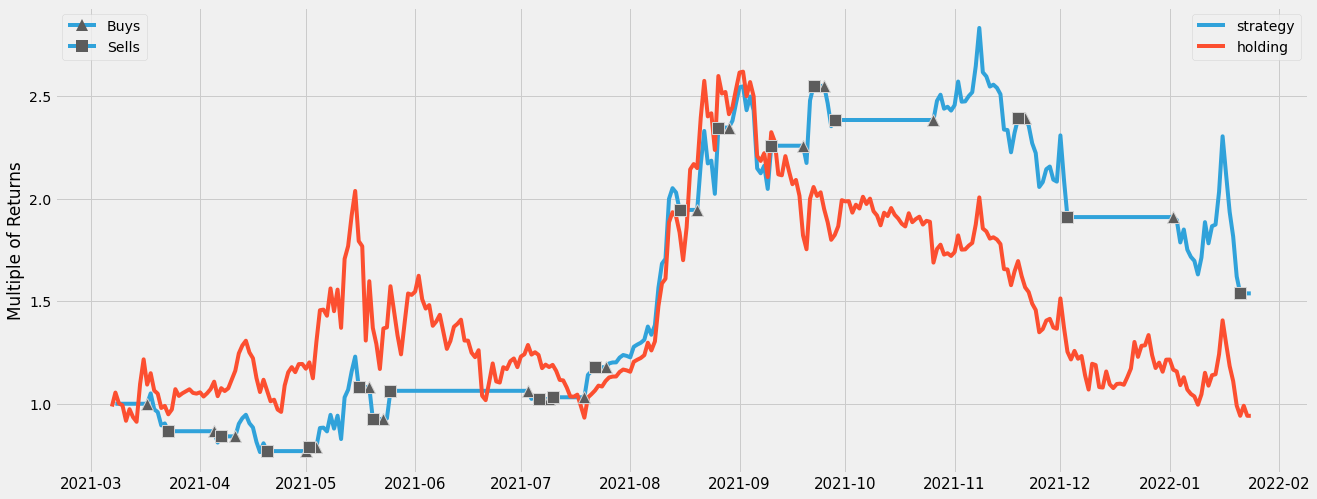

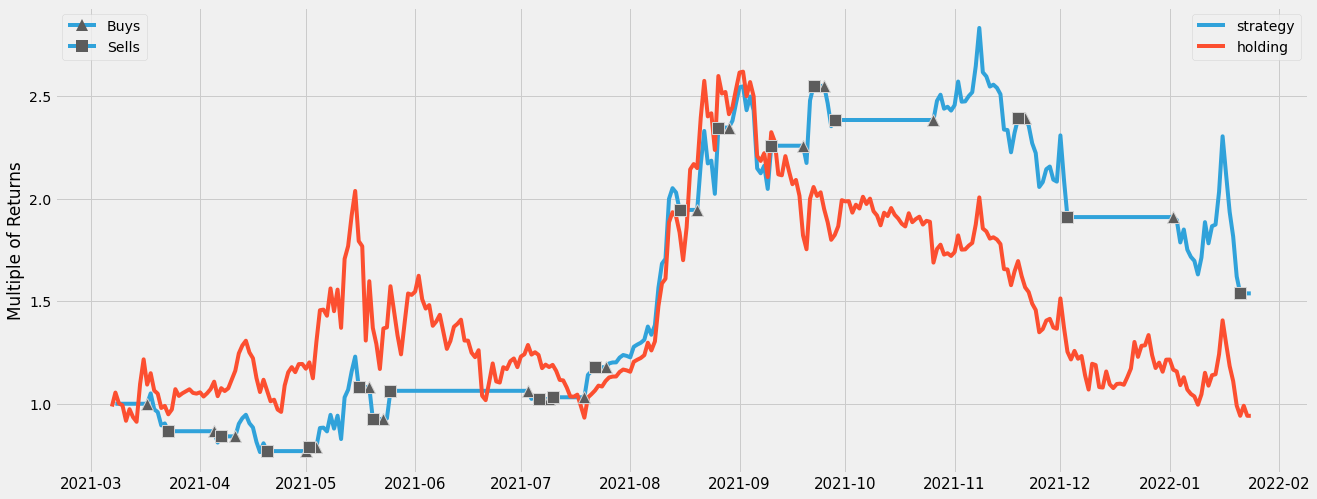

In [149]:
backtest_plotter(backtest_df, signal, backtest_lag)

In [150]:
subs_action.append(daily_signal(backtest_df, data_type, signal, coin, ticker))

## Signal Aggregation

In [151]:
twitter_signals_df = pd.DataFrame()

coin_series = [coin] #making a list to put into dataframe
twitter_signals_df['Coin'] = coin_series
twitter_signals_df['retweets_action'] = retweets_action
twitter_signals_df['retweets_hitrate'] = retweets_hitrate
twitter_signals_df['favorites_action'] = favorites_action
twitter_signals_df['favorites_hitrate'] = favorites_hitrate
twitter_signals_df['followers_action'] = followers_action
twitter_signals_df['followers_hitrate'] = followers_hitrate

twitter_signals_df

Coin retweets_action  retweets_hitrate favorites_action  \
0  cardano   Keep Position              0.52    Keep Position   

   favorites_hitrate followers_action  followers_hitrate  
0           0.513846    Keep Position           0.590769

Coin retweets_action  retweets_hitrate favorites_action  \
0  cardano   Keep Position              0.52    Keep Position   

   favorites_hitrate followers_action  followers_hitrate  
0           0.513846    Keep Position           0.590769

Coin retweets_action  retweets_hitrate favorites_action  \
0  cardano   Keep Position              0.52    Keep Position   

   favorites_hitrate followers_action  followers_hitrate  
0           0.513846    Keep Position           0.590769

In [152]:
reddit_signals_df = pd.DataFrame()

coin_series = [coin] #making a list to put into dataframe
reddit_signals_df['Coin'] = coin_series
reddit_signals_df['num_comms_action'] = num_comms_action
reddit_signals_df['num_comms_hitrate'] = num_comms_hitrate
reddit_signals_df['score_action'] = score_action
reddit_signals_df['score_hitrate'] = score_hitrate
reddit_signals_df['subs_action'] = subs_action
reddit_signals_df['subs_hitrate'] = subs_hitrate

reddit_signals_df

Coin num_comms_action  num_comms_hitrate   score_action  score_hitrate  \
0  cardano    Keep Position           0.461538  Keep Position       0.547692   

     subs_action  subs_hitrate  
0  Keep Position      0.569231

Coin num_comms_action  num_comms_hitrate   score_action  score_hitrate  \
0  cardano    Keep Position           0.461538  Keep Position       0.547692   

     subs_action  subs_hitrate  
0  Keep Position      0.569231

Coin num_comms_action  num_comms_hitrate   score_action  score_hitrate  \
0  cardano    Keep Position           0.461538  Keep Position       0.547692   

     subs_action  subs_hitrate  
0  Keep Position      0.569231

In [153]:
corr_tracker(cardano_df, 90)

subreddit_subs  num_comms     score  retweet_count  \
subreddit_subs           1.000000   0.768793  0.722190       0.279397   
num_comms                0.768793   1.000000  0.915346       0.013435   
score                    0.722190   0.915346  1.000000      -0.040064   
retweet_count            0.279397   0.013435 -0.040064       1.000000   
favorite_count           0.375285   0.163490  0.120741       0.956821   
account_followers        0.895926   0.706811  0.711789       0.131609   

                   favorite_count  account_followers  
subreddit_subs           0.375285           0.895926  
num_comms                0.163490           0.706811  
score                    0.120741           0.711789  
retweet_count            0.956821           0.131609  
favorite_count           1.000000           0.208831  
account_followers        0.208831           1.000000

subreddit_subs  num_comms     score  retweet_count  \
subreddit_subs           1.000000   0.768793  0.722190       0.279397   
num_comms                0.768793   1.000000  0.915346       0.013435   
score                    0.722190   0.915346  1.000000      -0.040064   
retweet_count            0.279397   0.013435 -0.040064       1.000000   
favorite_count           0.375285   0.163490  0.120741       0.956821   
account_followers        0.895926   0.706811  0.711789       0.131609   

                   favorite_count  account_followers  
subreddit_subs           0.375285           0.895926  
num_comms                0.163490           0.706811  
score                    0.120741           0.711789  
retweet_count            0.956821           0.131609  
favorite_count           1.000000           0.208831  
account_followers        0.208831           1.000000

subreddit_subs  num_comms     score  retweet_count  \
subreddit_subs           1.000000   0.768793  0.722190       0.279397   
num_comms                0.768793   1.000000  0.915346       0.013435   
score                    0.722190   0.915346  1.000000      -0.040064   
retweet_count            0.279397   0.013435 -0.040064       1.000000   
favorite_count           0.375285   0.163490  0.120741       0.956821   
account_followers        0.895926   0.706811  0.711789       0.131609   

                   favorite_count  account_followers  
subreddit_subs           0.375285           0.895926  
num_comms                0.163490           0.706811  
score                    0.120741           0.711789  
retweet_count            0.956821           0.131609  
favorite_count           1.000000           0.208831  
account_followers        0.208831           1.000000

In [154]:
#Choosing Signals Based on Hit Rate and Correlation (retweets, followers, score)

cardano_signals = pd.merge(reddit_signals_df, twitter_signals_df)
cardano_signals = cardano_signals.drop(['subs_action', 'subs_hitrate', 'num_comms_action', 'num_comms_hitrate',
                                       'favorites_action', 'favorites_hitrate'], axis = 1)
cardano_signals

Coin   score_action  score_hitrate retweets_action  retweets_hitrate  \
0  cardano  Keep Position       0.547692   Keep Position              0.52   

  followers_action  followers_hitrate  
0    Keep Position           0.590769

Coin   score_action  score_hitrate retweets_action  retweets_hitrate  \
0  cardano  Keep Position       0.547692   Keep Position              0.52   

  followers_action  followers_hitrate  
0    Keep Position           0.590769

Coin   score_action  score_hitrate retweets_action  retweets_hitrate  \
0  cardano  Keep Position       0.547692   Keep Position              0.52   

  followers_action  followers_hitrate  
0    Keep Position           0.590769

In [155]:
#Weighing Chosen Signals by Exponential Function
sig1_weight = 5*(cardano_signals['score_hitrate'][0] - 0.5)
sig2_weight = 5*(cardano_signals['retweets_hitrate'][0] - 0.5)
sig3_weight = 5*(cardano_signals['followers_hitrate'][0] - 0.5)

## Aggregated Signal Backtest

In [156]:
cardano_reddit_df = filter_df(reddit_df, 'reddit', coin, ticker) #dataframe that goes into everything
cardano_reddit_df['subreddit_subs'] = cardano_reddit_df['subreddit_subs'].diff() #adjusting subreddit_subs so it's more useful

cardano_twitter_df = filter_df(twitter_df, 'twitter', coin, ticker) #dataframe that goes into everything
cardano_twitter_df['account_followers'] = cardano_twitter_df['account_followers'].diff() #adjusting subreddit_subs so it's more useful

cardano_df = pd.merge(cardano_reddit_df, cardano_twitter_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed




In [157]:
cardano_df = cardano_df.rename(columns={"subreddit": "coin"})
cardano_df = cardano_df.drop(['user_name'], axis = 1)

In [158]:
cardano_df

date_scrape     coin  subreddit_subs   num_comms       score     Close  \
0    2021-03-07  cardano             NaN  119.992000  301.224000  1.133367   
1    2021-03-08  cardano             NaN  121.240000  302.326000  1.118053   
2    2021-03-09  cardano             NaN  121.736000  306.388000  1.195161   
3    2021-03-10  cardano          1770.0  122.068000  311.942000  1.135003   
4    2021-03-11  cardano          1596.0  123.092000  316.998000  1.124790   
..          ...      ...             ...         ...         ...       ...   
320  2022-01-21  cardano           334.0  100.469758  203.489919  1.123233   
321  2022-01-22  cardano           396.0  101.766129  205.822581  1.066716   
322  2022-01-23  cardano           415.0  102.655242  203.756048  1.122371   
323  2022-01-24  cardano           354.0  103.340726  203.955645  1.066598   
324  2022-01-25  cardano           260.0  103.774194  204.483871  1.066598   

     retweet_count  favorite_count  account_followers  
0           99.400         592.200                NaN  
1           45.100         303.200            1927.00  
2           49.800         314.200            2112.00  
3           43.700         332.100            1814.00  
4           47.500         332.700            2473.00  
..             ...             ...                ...  
320        175.625         997.125            1682.00  
321        176.875        1001.125            1310.00  
322        171.000         960.500            1231.25  
323         90.750         530.625            1391.75  
324         92.000         522.800            1519.00  

[325 rows x 9 columns]

date_scrape     coin  subreddit_subs   num_comms       score     Close  \
0    2021-03-07  cardano             NaN  119.992000  301.224000  1.133367   
1    2021-03-08  cardano             NaN  121.240000  302.326000  1.118053   
2    2021-03-09  cardano             NaN  121.736000  306.388000  1.195161   
3    2021-03-10  cardano          1770.0  122.068000  311.942000  1.135003   
4    2021-03-11  cardano          1596.0  123.092000  316.998000  1.124790   
..          ...      ...             ...         ...         ...       ...   
320  2022-01-21  cardano           334.0  100.469758  203.489919  1.123233   
321  2022-01-22  cardano           396.0  101.766129  205.822581  1.066716   
322  2022-01-23  cardano           415.0  102.655242  203.756048  1.122371   
323  2022-01-24  cardano           354.0  103.340726  203.955645  1.066598   
324  2022-01-25  cardano           260.0  103.774194  204.483871  1.066598   

     retweet_count  favorite_count  account_followers  
0           99.400         592.200                NaN  
1           45.100         303.200            1927.00  
2           49.800         314.200            2112.00  
3           43.700         332.100            1814.00  
4           47.500         332.700            2473.00  
..             ...             ...                ...  
320        175.625         997.125            1682.00  
321        176.875        1001.125            1310.00  
322        171.000         960.500            1231.25  
323         90.750         530.625            1391.75  
324         92.000         522.800            1519.00  

[325 rows x 9 columns]

date_scrape     coin  subreddit_subs   num_comms       score     Close  \
0    2021-03-07  cardano             NaN  119.992000  301.224000  1.133367   
1    2021-03-08  cardano             NaN  121.240000  302.326000  1.118053   
2    2021-03-09  cardano             NaN  121.736000  306.388000  1.195161   
3    2021-03-10  cardano          1770.0  122.068000  311.942000  1.135003   
4    2021-03-11  cardano          1596.0  123.092000  316.998000  1.124790   
..          ...      ...             ...         ...         ...       ...   
320  2022-01-21  cardano           334.0  100.469758  203.489919  1.123233   
321  2022-01-22  cardano           396.0  101.766129  205.822581  1.066716   
322  2022-01-23  cardano           415.0  102.655242  203.756048  1.122371   
323  2022-01-24  cardano           354.0  103.340726  203.955645  1.066598   
324  2022-01-25  cardano           260.0  103.774194  204.483871  1.066598   

     retweet_count  favorite_count  account_followers  
0           99.400         592.200                NaN  
1           45.100         303.200            1927.00  
2           49.800         314.200            2112.00  
3           43.700         332.100            1814.00  
4           47.500         332.700            2473.00  
..             ...             ...                ...  
320        175.625         997.125            1682.00  
321        176.875        1001.125            1310.00  
322        171.000         960.500            1231.25  
323         90.750         530.625            1391.75  
324         92.000         522.800            1519.00  

[325 rows x 9 columns]

In [159]:
cols = cardano_df.columns.tolist()
cols = cols[0:5] + cols[6:] + cols[5:6]
cardano_df = cardano_df[cols]
cardano_df

date_scrape     coin  subreddit_subs   num_comms       score  \
0    2021-03-07  cardano             NaN  119.992000  301.224000   
1    2021-03-08  cardano             NaN  121.240000  302.326000   
2    2021-03-09  cardano             NaN  121.736000  306.388000   
3    2021-03-10  cardano          1770.0  122.068000  311.942000   
4    2021-03-11  cardano          1596.0  123.092000  316.998000   
..          ...      ...             ...         ...         ...   
320  2022-01-21  cardano           334.0  100.469758  203.489919   
321  2022-01-22  cardano           396.0  101.766129  205.822581   
322  2022-01-23  cardano           415.0  102.655242  203.756048   
323  2022-01-24  cardano           354.0  103.340726  203.955645   
324  2022-01-25  cardano           260.0  103.774194  204.483871   

     retweet_count  favorite_count  account_followers     Close  
0           99.400         592.200                NaN  1.133367  
1           45.100         303.200            1927.00  1.118053  
2           49.800         314.200            2112.00  1.195161  
3           43.700         332.100            1814.00  1.135003  
4           47.500         332.700            2473.00  1.124790  
..             ...             ...                ...       ...  
320        175.625         997.125            1682.00  1.123233  
321        176.875        1001.125            1310.00  1.066716  
322        171.000         960.500            1231.25  1.122371  
323         90.750         530.625            1391.75  1.066598  
324         92.000         522.800            1519.00  1.066598  

[325 rows x 9 columns]

date_scrape     coin  subreddit_subs   num_comms       score  \
0    2021-03-07  cardano             NaN  119.992000  301.224000   
1    2021-03-08  cardano             NaN  121.240000  302.326000   
2    2021-03-09  cardano             NaN  121.736000  306.388000   
3    2021-03-10  cardano          1770.0  122.068000  311.942000   
4    2021-03-11  cardano          1596.0  123.092000  316.998000   
..          ...      ...             ...         ...         ...   
320  2022-01-21  cardano           334.0  100.469758  203.489919   
321  2022-01-22  cardano           396.0  101.766129  205.822581   
322  2022-01-23  cardano           415.0  102.655242  203.756048   
323  2022-01-24  cardano           354.0  103.340726  203.955645   
324  2022-01-25  cardano           260.0  103.774194  204.483871   

     retweet_count  favorite_count  account_followers     Close  
0           99.400         592.200                NaN  1.133367  
1           45.100         303.200            1927.00  1.118053  
2           49.800         314.200            2112.00  1.195161  
3           43.700         332.100            1814.00  1.135003  
4           47.500         332.700            2473.00  1.124790  
..             ...             ...                ...       ...  
320        175.625         997.125            1682.00  1.123233  
321        176.875        1001.125            1310.00  1.066716  
322        171.000         960.500            1231.25  1.122371  
323         90.750         530.625            1391.75  1.066598  
324         92.000         522.800            1519.00  1.066598  

[325 rows x 9 columns]

date_scrape     coin  subreddit_subs   num_comms       score  \
0    2021-03-07  cardano             NaN  119.992000  301.224000   
1    2021-03-08  cardano             NaN  121.240000  302.326000   
2    2021-03-09  cardano             NaN  121.736000  306.388000   
3    2021-03-10  cardano          1770.0  122.068000  311.942000   
4    2021-03-11  cardano          1596.0  123.092000  316.998000   
..          ...      ...             ...         ...         ...   
320  2022-01-21  cardano           334.0  100.469758  203.489919   
321  2022-01-22  cardano           396.0  101.766129  205.822581   
322  2022-01-23  cardano           415.0  102.655242  203.756048   
323  2022-01-24  cardano           354.0  103.340726  203.955645   
324  2022-01-25  cardano           260.0  103.774194  204.483871   

     retweet_count  favorite_count  account_followers     Close  
0           99.400         592.200                NaN  1.133367  
1           45.100         303.200            1927.00  1.118053  
2           49.800         314.200            2112.00  1.195161  
3           43.700         332.100            1814.00  1.135003  
4           47.500         332.700            2473.00  1.124790  
..             ...             ...                ...       ...  
320        175.625         997.125            1682.00  1.123233  
321        176.875        1001.125            1310.00  1.066716  
322        171.000         960.500            1231.25  1.122371  
323         90.750         530.625            1391.75  1.066598  
324         92.000         522.800            1519.00  1.066598  

[325 rows x 9 columns]

In [160]:
#x is the trigger amount, y is the window, and z is the lag
def backtesting_all_signals(timeframe, df, signal1, signal2, signal3, window, lag, buy_trig_shift1, sell_trig_shift1, buy_trig_shift2, sell_trig_shift2, buy_trig_shift3, sell_trig_shift3, fee):
    #Creating columns that show returns and percent changes for signal
    
    backtest_df = df.copy()
    
    new_df = backtest_df.drop(['date_scrape', 'coin', 'Close'], axis=1)
    
    scaler = MinMaxScaler() 
    scaled_df = scaler.fit_transform(new_df)
    
    #adding functionality to determine which columns are metrics
    metric_cols = metric_finder(backtest_df)
    counter = 0
    
    
    for i in metric_cols:
        backtest_df[backtest_df.columns.values[i]] = scaled_df[:, [0+counter]]
        counter += 1
    
    
    backtest_df['returns'] = backtest_df['Close'].pct_change()
    backtest_df['sig_movement1'] = backtest_df[signal1].pct_change()
    backtest_df['sig_movement2'] = backtest_df[signal2].pct_change()
    backtest_df['sig_movement3'] = backtest_df[signal3].pct_change()
    #Adding column with returns affected by fees (will factor in fees later)
    backtest_df['fee_returns'] = backtest_df['returns']
    
    #Hold is a list that runs through every day and determines if we should hold, starts false bc we start not bought in
    hold = [False]
    
    
    cum_sig_mov1 = 1 #cumulative signal movement
    cum_sig_mov2 = 1 #cumulative signal movement
    cum_sig_mov3 = 1 #cumulative signal movement
    #trigger is by default average signal movement, can be shifted by certain amount of std devs
    
    sig_move_mean1 = backtest_df[backtest_df['sig_movement1'] != np.inf]['sig_movement1'][-1*timeframe:].mean()
    sig_move_std1 = backtest_df[backtest_df['sig_movement1'] != np.inf]['sig_movement1'][-1*timeframe:].std()
    
    sig_move_mean2 = backtest_df[backtest_df['sig_movement2'] != np.inf]['sig_movement2'][-1*timeframe:].mean()
    sig_move_std2 = backtest_df[backtest_df['sig_movement2'] != np.inf]['sig_movement2'][-1*timeframe:].std()
    
    sig_move_mean3 = backtest_df[backtest_df['sig_movement3'] != np.inf]['sig_movement3'][-1*timeframe:].mean()
    sig_move_std3 = backtest_df[backtest_df['sig_movement3'] != np.inf]['sig_movement3'][-1*timeframe:].std()
    
    buy_trigger1 = sig_move_mean1 + (sig_move_std1 * buy_trig_shift1)
    sell_trigger1 = sig_move_mean1 + (sig_move_std1 * sell_trig_shift1)
    
    buy_trigger2 = sig_move_mean2 + (sig_move_std2 * buy_trig_shift2)
    sell_trigger2 = sig_move_mean2 + (sig_move_std2 * sell_trig_shift2)
    
    buy_trigger3 = sig_move_mean3 + (sig_move_std3 * buy_trig_shift3)
    sell_trigger3 = sig_move_mean3 + (sig_move_std3 * sell_trig_shift3)
    
    print("buy: " + str(buy_trigger1))
    print("sell: " + str(sell_trigger1))
    
    print("buy: " + str(buy_trigger2))
    print("sell: " + str(sell_trigger2))
    
    print("buy: " + str(buy_trigger3))
    print("sell: " + str(sell_trigger3))
    
    
    for i in np.arange(1, len(df)):
        cum_sig_mov1 = cum_sig_mov1 + (cum_sig_mov1 * backtest_df['sig_movement1'][i]) #Calculating cumulative signal movement
        
        cum_sig_mov2 = cum_sig_mov2 + (cum_sig_mov2 * backtest_df['sig_movement2'][i]) #Calculating cumulative signal movement
        
        cum_sig_mov3 = cum_sig_mov3 + (cum_sig_mov3 * backtest_df['sig_movement3'][i]) #Calculating cumulative signal movement
        
        
        if(i%window == 0):
            cum_sig_mov1 = 1 #Resetting cumulative signal movement when window expires
            cum_sig_mov2 = 1 #Resetting cumulative signal movement when window expires
            cum_sig_mov3 = 1 #Resetting cumulative signal movement when window expires
            
        #sell conditions
        condition1 = (cum_sig_mov1 < (1 - sell_trigger1))
        condition2 = (cum_sig_mov2 < (1 - sell_trigger2))
        condition3 = (cum_sig_mov3 < (1 - sell_trigger3))
        #buy conditions
        condition4 = (cum_sig_mov1 > (1 + buy_trigger1))
        condition5 = (cum_sig_mov2 > (1 + buy_trigger2))
        condition6 = (cum_sig_mov3 > (1 + buy_trigger3))
        
        #Entire strategy  
        
        if ((int(condition1) + int(condition2) + 2*int(condition3)) >= 2): #If cumulative movement within the window decreases more than the trigger, sell
            hold.append(False)
            if(i+lag) < len(df): #Avoiding index error
                backtest_df['fee_returns'][i+lag] = backtest_df['returns'][i+lag] - (abs(backtest_df['returns'][i+lag]) * (fee))
        elif ((int(condition4) + int(condition5) + 2*int(condition6)) >= 2): #If cumulative movement within the window increases more than the trigger, buy
            hold.append(True)
            if(i+lag) < len(df): #Avoiding index error
                backtest_df['fee_returns'][i+lag] = backtest_df['returns'][i+lag] - (abs(backtest_df['returns'][i+lag]) * (fee))
        else:    
            hold.append(hold[i-1]) #If cumulative movement within the window doesn't exceed trigger on either end, don't trade
        
    
    backtest_df['hold'] = hold #Turns holds into series
    
    #Backtests, cumulatively multiplies returns where hold is true, shifts returns by lag specified
    backtest_df['strategy_perf'] = (backtest_df['fee_returns'].shift(-1 + (lag * -1)) * backtest_df['hold'] + 1).cumprod()
    backtest_df['holding_perf'] = (backtest_df['returns'].shift(-1) + 1).cumprod()  # benchmark returns
    backtest_df.to_csv(str(signal) + 'dataframe.csv')
    
    return backtest_df

In [161]:
#This is where you specify details of the report (what API, how many lag days, moving average)
dataframe = cardano_df
signal1 = 'score'
signal2 = 'retweet_count'
signal3 = 'account_followers'
moving_avg = 0 #Smooths signal, takes average across specified window 
backtest_lag = 1 #Calculates predictive power into the future by lagging prices by x amount of days


#backtest variables
window = 3 #Length of days in which if signal goes up/down it would qualify as a buy/sell trigger
timeframe = 60 #How many days of past data to use to set as benchmark signal movement
buy_shift1 = 0.25 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift1 = 0.25
buy_shift2 = 0.25 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift2 = 0.25
buy_shift3 = 0.25 #trigger defaults to average signal movement, this variable shifts that by x amount of std devs
sell_shift3 = 0.25
fee = 0.01
risk_free_rate = 0.0119

In [162]:
backtest_df = backtesting_all_signals(timeframe, dataframe, signal1, signal2, signal3, window, backtest_lag, buy_shift1, sell_shift1, buy_shift2, sell_shift2, buy_shift3, sell_shift3, fee)

buy: 0.03223650059980194
sell: 0.03223650059980194
buy: 0.05536468094367609
sell: 0.05536468094367609
buy: 0.00012229152293955053
sell: 0.00012229152293955053
buy: 0.03223650059980194
sell: 0.03223650059980194
buy: 0.05536468094367609
sell: 0.05536468094367609
buy: 0.00012229152293955053
sell: 0.00012229152293955053
buy: 0.03223650059980194
sell: 0.03223650059980194
buy: 0.05536468094367609
sell: 0.05536468094367609
buy: 0.00012229152293955053
sell: 0.00012229152293955053


In [163]:
backtest_df.tail(10)

date_scrape     coin  subreddit_subs  num_comms     score  ...  \
315  2022-01-16  cardano        0.496721   0.415395  0.028870  ...   
316  2022-01-17  cardano        0.497131   0.403157  0.018751  ...   
317  2022-01-18  cardano        0.496886   0.406295  0.024293  ...   
318  2022-01-19  cardano        0.496686   0.401588  0.022404  ...   
319  2022-01-20  cardano        0.496589   0.399275  0.014831  ...   
320  2022-01-21  cardano        0.496404   0.401062  0.000000  ...   
321  2022-01-22  cardano        0.496501   0.412908  0.004339  ...   
322  2022-01-23  cardano        0.496530   0.421032  0.000495  ...   
323  2022-01-24  cardano        0.496435   0.427295  0.000866  ...   
324  2022-01-25  cardano        0.496289   0.431256  0.001849  ...   

     sig_movement3  fee_returns   hold  strategy_perf  holding_perf  
315       0.001846     0.084765  False       2.384569      1.406544  
316       0.001934     0.132798   True       2.181147      1.293086  
317      -0.001068    -0.081471   True       2.045082      1.183868  
318      -0.001755    -0.085308   True       1.823725      1.110016  
319      -0.000470    -0.062382  False       1.823725      0.991059  
320      -0.000146    -0.108239  False       1.823725      0.941192  
321      -0.000473    -0.050820  False       1.823725      0.990298  
322      -0.000100     0.052174  False       1.823725      0.941088  
323       0.000204    -0.049692  False            NaN      0.941088  
324       0.000162     0.000000  False            NaN           NaN  

[10 rows x 17 columns]

date_scrape     coin  subreddit_subs  num_comms     score  ...  \
315  2022-01-16  cardano        0.496721   0.415395  0.028870  ...   
316  2022-01-17  cardano        0.497131   0.403157  0.018751  ...   
317  2022-01-18  cardano        0.496886   0.406295  0.024293  ...   
318  2022-01-19  cardano        0.496686   0.401588  0.022404  ...   
319  2022-01-20  cardano        0.496589   0.399275  0.014831  ...   
320  2022-01-21  cardano        0.496404   0.401062  0.000000  ...   
321  2022-01-22  cardano        0.496501   0.412908  0.004339  ...   
322  2022-01-23  cardano        0.496530   0.421032  0.000495  ...   
323  2022-01-24  cardano        0.496435   0.427295  0.000866  ...   
324  2022-01-25  cardano        0.496289   0.431256  0.001849  ...   

     sig_movement3  fee_returns   hold  strategy_perf  holding_perf  
315       0.001846     0.084765  False       2.384569      1.406544  
316       0.001934     0.132798   True       2.181147      1.293086  
317      -0.001068    -0.081471   True       2.045082      1.183868  
318      -0.001755    -0.085308   True       1.823725      1.110016  
319      -0.000470    -0.062382  False       1.823725      0.991059  
320      -0.000146    -0.108239  False       1.823725      0.941192  
321      -0.000473    -0.050820  False       1.823725      0.990298  
322      -0.000100     0.052174  False       1.823725      0.941088  
323       0.000204    -0.049692  False            NaN      0.941088  
324       0.000162     0.000000  False            NaN           NaN  

[10 rows x 17 columns]

date_scrape     coin  subreddit_subs  num_comms     score  ...  \
315  2022-01-16  cardano        0.496721   0.415395  0.028870  ...   
316  2022-01-17  cardano        0.497131   0.403157  0.018751  ...   
317  2022-01-18  cardano        0.496886   0.406295  0.024293  ...   
318  2022-01-19  cardano        0.496686   0.401588  0.022404  ...   
319  2022-01-20  cardano        0.496589   0.399275  0.014831  ...   
320  2022-01-21  cardano        0.496404   0.401062  0.000000  ...   
321  2022-01-22  cardano        0.496501   0.412908  0.004339  ...   
322  2022-01-23  cardano        0.496530   0.421032  0.000495  ...   
323  2022-01-24  cardano        0.496435   0.427295  0.000866  ...   
324  2022-01-25  cardano        0.496289   0.431256  0.001849  ...   

     sig_movement3  fee_returns   hold  strategy_perf  holding_perf  
315       0.001846     0.084765  False       2.384569      1.406544  
316       0.001934     0.132798   True       2.181147      1.293086  
317      -0.001068    -0.081471   True       2.045082      1.183868  
318      -0.001755    -0.085308   True       1.823725      1.110016  
319      -0.000470    -0.062382  False       1.823725      0.991059  
320      -0.000146    -0.108239  False       1.823725      0.941192  
321      -0.000473    -0.050820  False       1.823725      0.990298  
322      -0.000100     0.052174  False       1.823725      0.941088  
323       0.000204    -0.049692  False            NaN      0.941088  
324       0.000162     0.000000  False            NaN           NaN  

[10 rows x 17 columns]

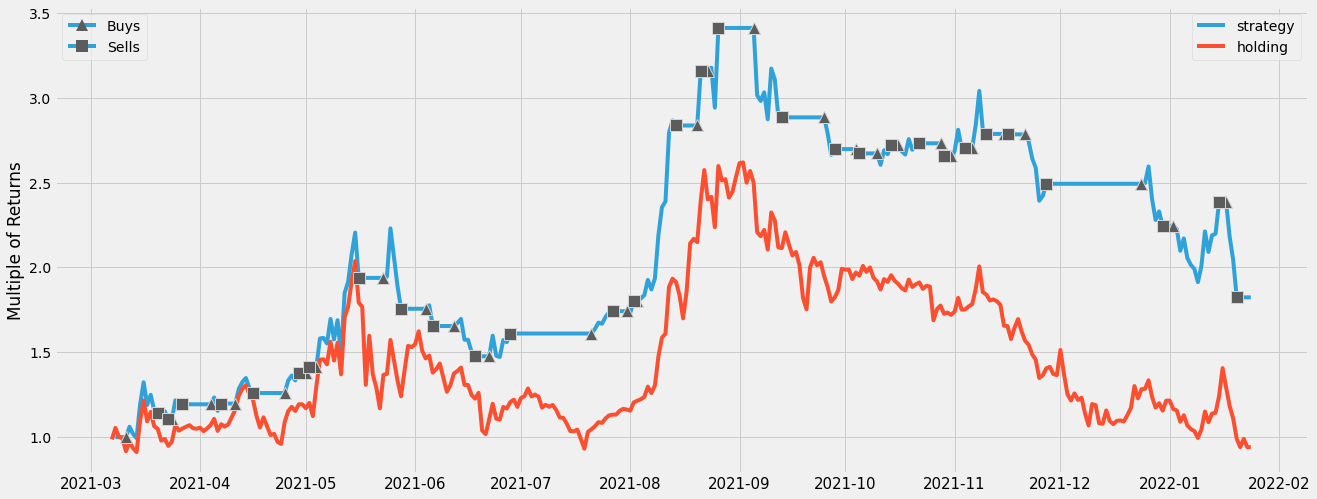

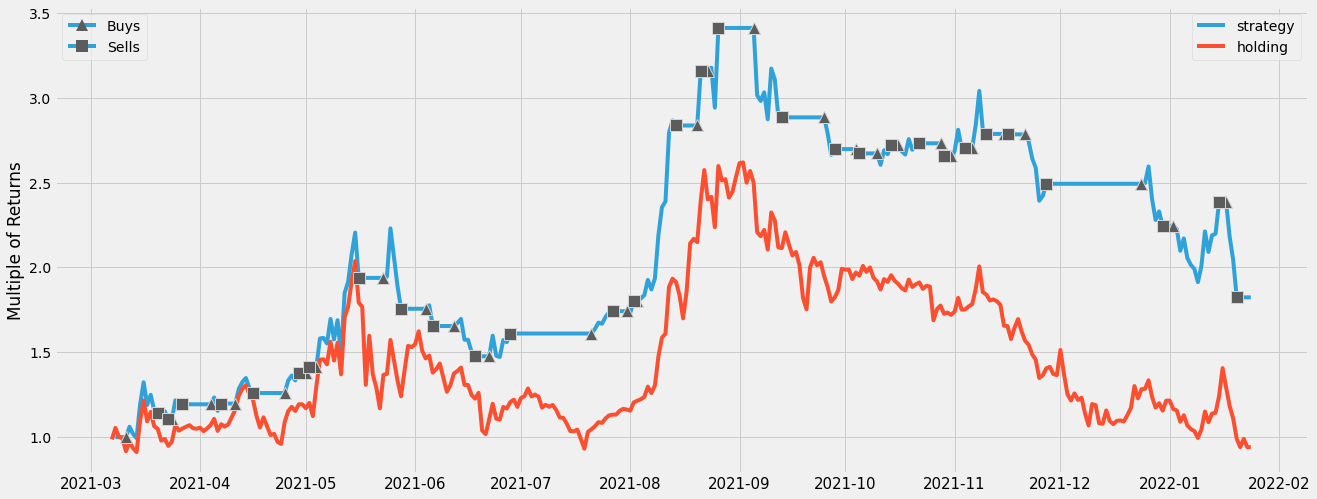

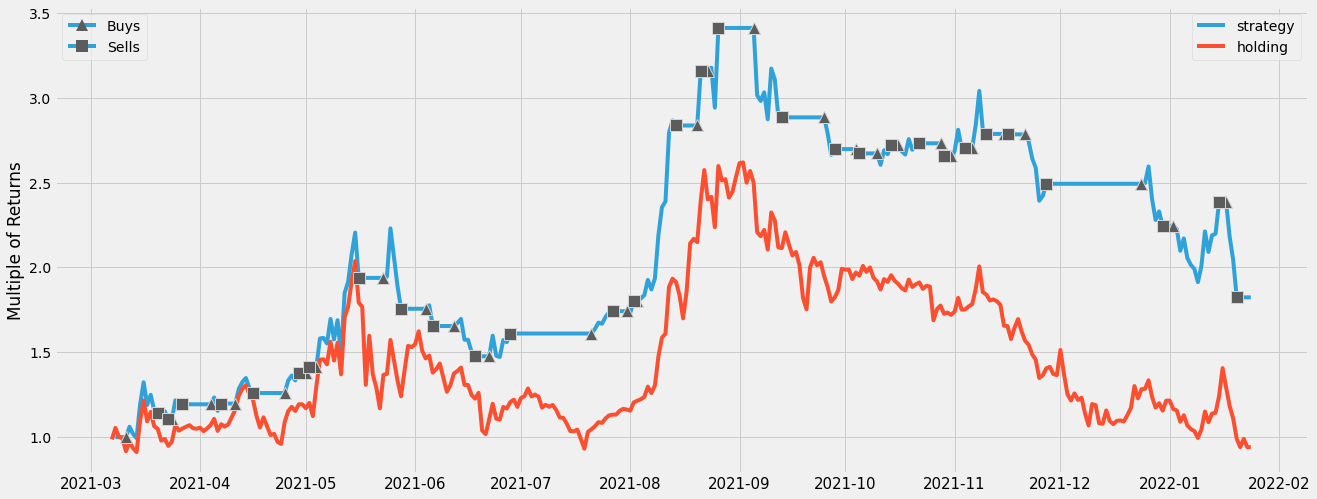

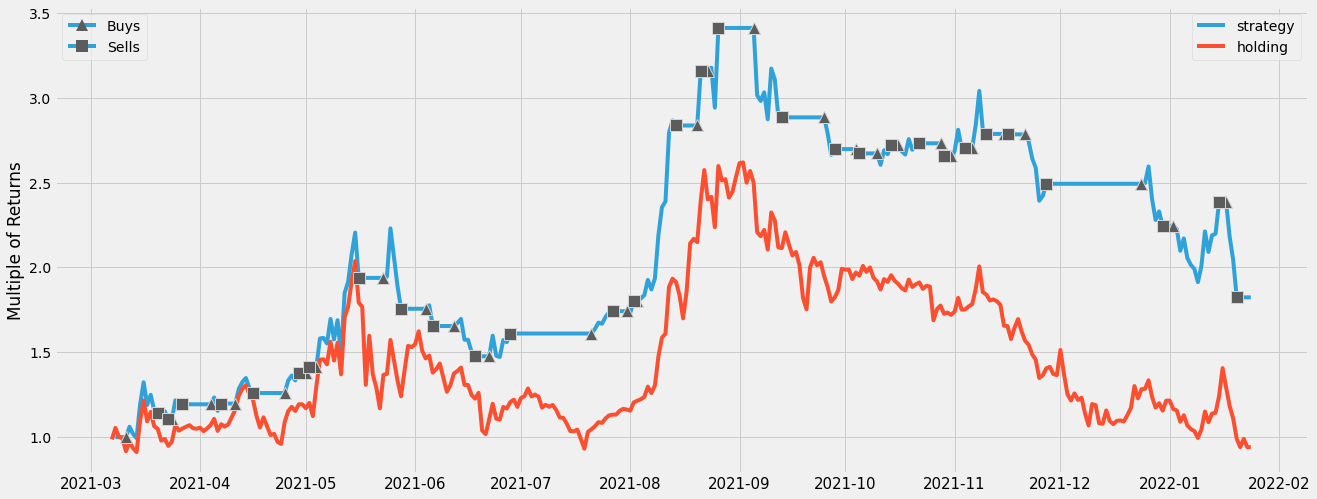

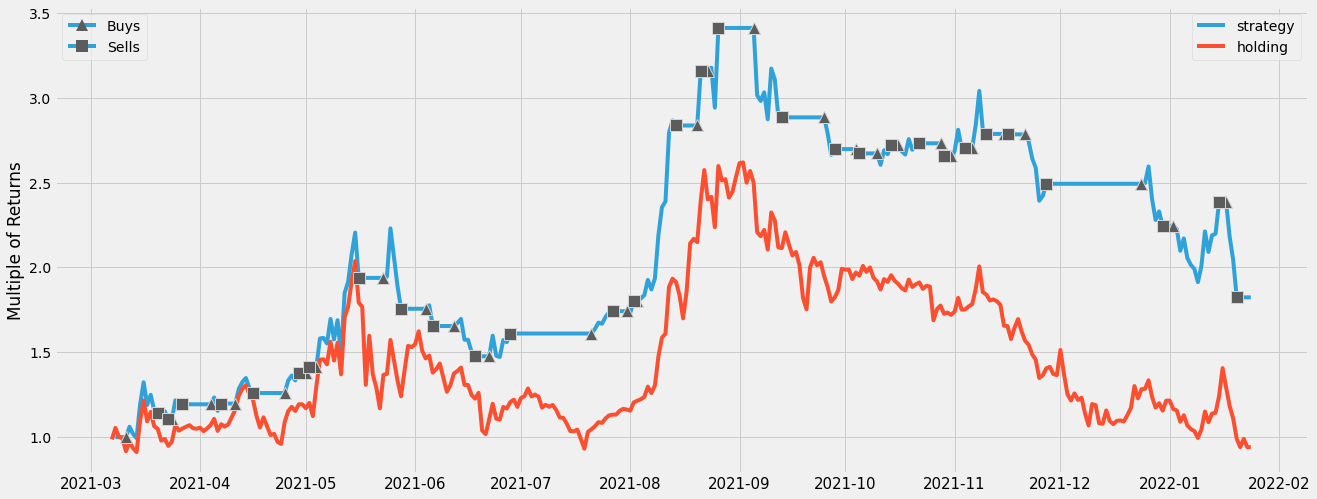

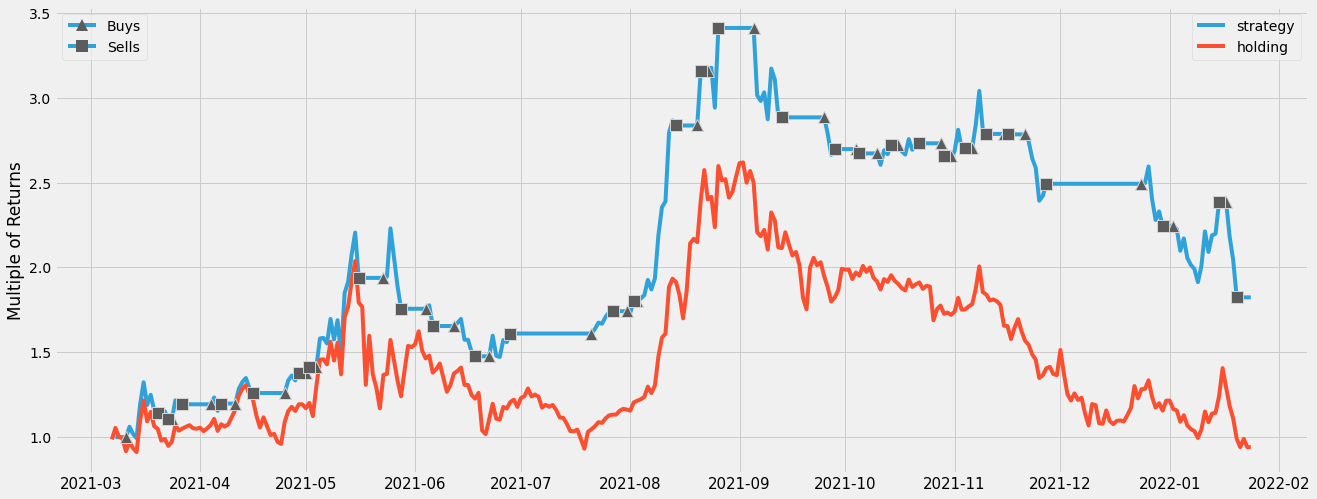

In [164]:
backtest_plotter(backtest_df, '', backtest_lag)

In [165]:
daily_signal(backtest_df, '', '', coin, ticker)

'Keep Position'

'Keep Position'

'Keep Position'